In [422]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# NOTES : Outline of all functions in order and useage 

### Function that loads in any coordinate velocity and mass data of a given halo and returns these as numpy array and saved .npy files

### Function that Creates radial bins and denisty hist values for a simple rho(r) plot, and also make V_dispersion Profile. These radial bins are later used to make V_disperison as well

### NOTE:  Make sure radial bins are reset so that they are in the binning value in the middle of the bin

# remember to plot the values at the middle of the bin (not the edges)

## Set the halo to be loaded for analysis

In [423]:
halo = 'juliet'   

In [424]:
import numpy as np
from random import seed
from random import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import matplotlib as mpl

# Must use aitoff module from Case Western
import aitoff as at
from matplotlib.backends.backend_pdf import PdfPages
d = 8.3   # kpc

conversion =  ( (1.989e30  * 5.586792179e26) **2 /  ((3.086e21)**5  )  )  # Conversion from Solar masses to particle physics units
plot_bins = 80

path = "/Users/danmckeown/" 


# Functions 

# 1). 

In [425]:
def make_coords(coord_file,mass,velocities,mult_by):
    
    x = coord_file[:,0]
    y = coord_file[:,1]
    z = coord_file[:,2]  
            
    radius = np.sqrt(x*x + y*y  + z*z  )
    mask = radius <= my_rad
    radius_final = radius[mask]
    velocities_final = velocities[mask]
    velocities_final = np.asarray( velocities_final)
    part_mass = mass[0] * mult_by
    new_mass = np.zeros(len(radius_final))
    new_mass[:] = part_mass        
    x = x[mask]
    y = y[mask]
    z = z[mask]  
        
    return x,y,z,radius_final,new_mass,velocities_final,part_mass

In [426]:
def make_star_coords(coord_file,mass,velocities,mult_by):
    
    x = coord_file[:,0]
    y = coord_file[:,1]
    z = coord_file[:,2]  
            
    radius = np.sqrt(x*x + y*y  + z*z  )
    mask = radius <= my_rad
    radius_final = radius[mask]
    velocities_final = velocities[mask]
    velocities_final = np.asarray( velocities_final)
    part_mass = mass[0] * mult_by
    new_mass = np.zeros(len(radius_final))
    new_mass[:] = part_mass        
    x = x[mask]
    y = y[mask]
    z = z[mask]  
        
    return x,y,z,radius_final,new_mass,velocities_final,part_mass

# 2). 

In [427]:
def make_hist(radius,chosen_bins, masses, total_distance ):
    hist, bin_edges = np.histogram(radius, bins = chosen_bins, weights = masses, range = [0,total_distance])
    #...For Density plot                                                                                                                                                                        
    Vol = np.zeros(len(hist))
    for j in range(0, len(hist)):
        Vol[j] = 4.0/3.0* np.pi * (chosen_bins[j +1]**3 - chosen_bins[j]**3)
    
    # function adds an extra element we need to delete                                                                                                                                          
    chosen_bins_new = chosen_bins #chosen_bins[:-1]
    Den = list(map(truediv, hist, Vol))
    chosen_bins_new = np.asarray(chosen_bins_new)
    # Select the midpoint of each radial bin to plot
    chosen_bins_final =  (    chosen_bins_new[1:] + chosen_bins_new[:-1]) / 2.0 
    Den = np.asarray(Den)
    return chosen_bins_final,Den

# 3).

In [428]:
def make_velocities(velocities,radius,radial_bins,mult_by_vel):
    
    
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))

    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    velocities = velocities - v_av
    
    vx = velocities[:,0]
    vy = velocities[:,1]
    vz = velocities[:,2]
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))
    
    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    dispersion = np.zeros(radial_bins.size - 1)
 #   radial_bins = radial_bins[:-1]
    radial_bins_final =  ( radial_bins[1:] + radial_bins[:-1]) / 2.0 
    
    for i in range(1, len(radial_bins)): # Start at i = 1 since we're making shells                                                                                                                                                                        
     #   print (len(radius_dark),radial_bins_dark[i-1],radial_bins_dark[i]  )
        mask = (radius >  radial_bins[i-1]) & (radius < radial_bins[i])
        v_avg_dark = velocities[mask].mean(axis=0)
        difference_dark = velocities[mask] - v_avg_dark
        coord_var_dark = np.var(difference_dark, axis=0)
        dispersion[i-1] = np.sqrt(np.sum(coord_var_dark)) * mult_by_vel   
    return v_av,radial_bins_final,dispersion,vx,vy,vz

In [429]:
def make_star_velocities(velocities,radius,radial_bins,mult_by_vel):
    
    
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))

    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    velocities = velocities - v_av
    
    vx = velocities[:,0]
    vy = velocities[:,1]
    vz = velocities[:,2]
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))
    
    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    dispersion = np.zeros(radial_bins.size - 1)
 #   radial_bins = radial_bins[:-1]
    radial_bins_final =  ( radial_bins[1:] + radial_bins[:-1]) / 2.0 
    
    for i in range(1, len(radial_bins)): # Start at i = 1 since we're making shells                                                                                                                                                                        
     #   print (len(radius_dark),radial_bins_dark[i-1],radial_bins_dark[i]  )
        mask = (radius >  radial_bins[i-1]) & (radius < radial_bins[i])
        v_avg_dark = velocities[mask].mean(axis=0)
        difference_dark = velocities[mask] - v_avg_dark
        coord_var_dark = np.var(difference_dark, axis=0)
        dispersion[i-1] = np.sqrt(np.sum(coord_var_dark)) * mult_by_vel   
    return v_av,radial_bins_final,dispersion,vx,vy,vz

# 4). 

In [430]:
def local_density_weighting(file_name, radius, bin_edges,Den):

    rho_local = []
    #file_name = "rho_local_dm_m12i_new.npy"

    for i in range(len(radius)):

        local_d = (np.interp(radius[i] , bin_edges, Den, left= np.max(Den), right = np.min(Den), period=None))
        rho_local.insert( i, local_d )

    np.save(path+"/"+file_name+'.npy',rho_local)
    return rho_local
    

# 5).

In [431]:
def local_velocity_disp_weighting(file_name, radius, bin_edges, dispersion_sq):
    vel_disp_local_p = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_sq)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_p = (np.interp(radius[i] , bin_edges, dispersion_sq, left= dispersion_sq[0] , right= dispersion_sq[final_value], period=None))
        
        local_vel_p = ((local_vel_p) /( 2.99792458e5)**2 )        

        vel_disp_local_p.insert( i, local_vel_p )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_p)
    return vel_disp_local_p
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

# 6). 

In [432]:
def local_velocity_disp_weighting_d_wave(file_name, radius, bin_edges, dispersion_fourth):


    vel_disp_D_WAVE = []
    length = len(dispersion_fourth)
    final_value = length - 1    
   
    for i in range(len(radius )):

        local_vel_d = (np.interp(radius[i] , bin_edges, dispersion, left= dispersion_fourth[0], right= dispersion_fourth[final_value], period=None))
        local_vel_d = ((local_vel_d) /( 2.99792458e5)**4 )

        vel_disp_D_WAVE.insert( i, local_vel_d )

    np.save(path+"/"+file_name+'.npy',vel_disp_D_WAVE)
    return vel_disp_D_WAVE

# 7). 

In [433]:
def coord_trans( x,y,z,d,weights ):

    x = (x + d)
    
    Phi = np.arctan2(y ,x)
    radius = np.sqrt(( x  )*(  x ) + (y )* (y ) + (z )*(z  ) )        
    u = (z  )  / ( radius )
    Theta = np.arccos(u)
    
    Cos_Psi = (x) /(radius)
    
    a = 0.4
    # a is the softening length.  
    
    Angle_weighting =  ( weights) /  (radius + a)**2    # Weights can either be in terms of rho* density  or rho*density *sigma**2,  or rho* density * sigma**4
    
    
    return Phi,Theta,radius,Angle_weighting,Cos_Psi

In [434]:
def coord_trans_new( x,y,z,d,weights ):

    x = (x + d)
    
    Phi = np.arctan2(y ,x)
    radius = np.sqrt(( x  )*(  x ) + (y )* (y ) + (z )*(z  ) )        
    u = (z  )  / ( radius )
    Theta = np.arccos(u)
    
    Cos_Psi = (x) /(radius)
    
    #a = 0.4
    # a is the softening length.  
    
    #Angle_weighting =  ( weights) /  (radius + a)**2    # Weights can either be in terms of rho* density  or rho*density *sigma**2,  or rho* density * sigma**4
    
    
    return Phi,Theta,radius,weights,Cos_Psi

# NOTE: Just Use 7 for velocities and use velocities weights in place of weighting mass and rho ( in other words multiply it by that)

# 8).

In [435]:
def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-90.,90.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-45.,45.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)
    print( 'len binner') 
    print(len(binner1))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    #plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    plot = ax.imshow(img.T,origin='lower',
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat
    plt.contour (New_band ,colors='k');
    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    
    
    plt.contour (New_band ,colors='k');
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    
    
    ### Comment at.gridlines out 
    ###at.gridlines(lz,fig,ax)
    
    
    plt.contour (New_band ,colors='k');
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
    cax.get_xaxis().set_visible(True)
    ax.set_xlim([90.,-90.])
    ax.set_ylim([-45.,45.])
    
    plt.contour (New_band ,colors='k');
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    return xbins,ybins,img,l,b, Final_weighting



In [436]:
def hammer_projection_new(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type,calc):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-180.,180.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-90.,90.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    #img = np.log10(img)

    print(len(img))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat

    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[3],y_lim[1], calc , fontsize = 28, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
    cax.get_xaxis().set_visible(True)
    ax.set_xlim([90.,-90.])
    ax.set_ylim([-45.,45.])
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    return xbins,ybins



# 9). 

In [437]:
def Angle_convert( Theta,Phi):


    Theta_deg = np.degrees(Theta - np.pi/2)
    Phi_deg = np.degrees(Phi + np.pi)    

    Theta_deg_array = np.asarray( Theta_deg)
    Phi_deg_array = np.asarray( Phi_deg)

    
    return Theta_deg_array,Phi_deg_array


# 10).

In [438]:

def recenter( coords, dm_mass, center_range):

    radius = np.sqrt ( coords[:,0]*coords[:,0] +  coords[:,1]*coords[:,1] + coords[:,2]*coords[:,2] )

    index1 = radius < center_range

    xyz2 = coords[index1]
    
    dm_mass2 = dm_mass[index1]

    mp = 0
    for j in range (0, len(xyz2)):
    # sum all the mass times coordinates                                                                                                                                                                                                \

        mp = dm_mass2[j] * xyz2[j,:] + mp

    DM_mass_tot1 = len(xyz2) * dm_mass2[0]
    
    DM_cm = mp/DM_mass_tot1
    print ('printing dm cm')
    print (DM_cm)
    print(dm_mass2[0])
    new_coords = coords - DM_cm    
    
    
    return new_coords

# 11).

In [439]:

def recenter_bary( coords, dm_mass, center_range):

    radius = np.sqrt ( coords[:,0]*coords[:,0] +  coords[:,1]*coords[:,1] + coords[:,2]*coords[:,2] )

    index1 = radius < center_range

    xyz2 = coords[index1]
    
    dm_mass2 = dm_mass[index1]

    mp = 0
    for j in range (0, len(xyz2)):
    # sum all the mass times coordinates                                                                                                                                                                                                \

        mp = dm_mass2[j] * xyz2[j,:] + mp

    DM_mass_tot1 = len(xyz2) * dm_mass2[0]
    
    DM_cm = mp/DM_mass_tot1
    print ('printing dm cm')
    print (DM_cm)
    print(dm_mass2[0])
    new_coords_bary = coords - DM_cm    
    
    
    return new_coords_bary

#  NEED TO MAKE NOTES TO THIS SECTION OF CODE FOR CLAIRIFICATION 

# 12). 

In [440]:

import numpy as np
import ctypes
import math
import os.path
import struct
import array

def checklen(x):
    return len(np.array(x,ndmin=1));
def fcor(x):
    return np.array(x,dtype='f',ndmin=1)
def vfloat(x):
    return x.ctypes.data_as(ctypes.POINTER(ctypes.c_float));

def ok_scan(input,xmax=1.0e10,pos=0):
    if (pos==1):
        return (np.isnan(input)==False) & (abs(input)<=xmax) & (input > 0.);
    else:
        return (np.isnan(input)==False) & (abs(input)<=xmax);
    
    
    
    
def get_particle_hsml( x, y, z, vx, vy, vz, DesNgb=32, Hmax=0.):
    
    
    x=fcor(x); y=fcor(y); z=fcor(z); N=checklen(x); 

    vx=fcor(vx); vy=fcor(vy); vz=fcor(vz); N=checklen(x); 
    
    ok=(ok_scan(x) & ok_scan(y) & ok_scan(z));
    ok= ok & (ok_scan(vx) & ok_scan(vy) & ok_scan(vz));

    x=x[ok]; y=y[ok]; z=z[ok];
    vx=vx[ok]; vy=vy[ok]; vz=vz[ok];

    
    if(Hmax==0.):
        dx=np.max(x)-np.min(x); dy=np.max(y)-np.min(y); dz=np.max(z)-np.min(z); ddx=np.max([dx,dy,dz]);
        Hmax=5.*ddx*(np.float(N)**(-1./3.)); ## mean inter-particle spacing                                                                                                                                                                                   

  
  ##### now accessing the C code

    import inspect
    exec_call = "/Users/danmckeown/repos/FIRE_studio/firestudio/utils/stellar_utils/c_libraries/StellarHsml/starhsml.so"
    
    # calling program in the dir.
    h_routine=ctypes.cdll[exec_call];

    # These are python variables which we are casting as C variables
    h_out_cast=ctypes.c_float*N; H_OUT=h_out_cast();
    v_mag_cast=ctypes.c_float*N; V_MAG=v_mag_cast();
    v_out_cast=ctypes.c_float*N; V_OUT=v_out_cast();
    
    # First variable name needs to match last
    
    # These lines create the pointers that are passed to the C code  ( ctypes.byref(H_OUT), ctypes.byref(V_OUT))
    
    
    ## main call to the hsml-finding routine
    h_routine.stellarhsml( ctypes.c_int(N), \
    ## load the routine we need                                                                                                                                                                                                                               
    
        vfloat(x), vfloat(y), vfloat(z), \
        vfloat(vx), vfloat(vy), vfloat(vz), ctypes.c_int(DesNgb), \
        ctypes.c_float(Hmax), ctypes.byref(H_OUT), ctypes.byref(V_OUT),ctypes.byref(V_MAG)
    )                       
                          
    ## now put the output arrays into a useful format 
    
    # These two lines below get the pointers out
    h = np.ctypeslib.as_array(np.copy(H_OUT));                     
    vmag = np.ctypeslib.as_array(np.copy(V_MAG));

    vdisp = np.ctypeslib.as_array(np.copy(V_OUT));
    
    return h, vmag, vdisp
                          
   

# Files 

In [441]:
R_virial_bary =  np.load(path+"/"+'Virial_juliet_bary.npy')

R_virial_dark =  np.load(path+"/"+'virial_MW.npy')


velocities_bary = np.load(path+"/"+ 'velocities_dm_baryrj_Juliet.npy')

bary_coords = np.load(path+"/"+ 'bary_coord_dm_rj_Juliet_newest.npy')


# dm_mass_bary  = np.load(path+"/"+ 'dm_mass_unrot_bary_romeoJuliet.npy' )

dm_mass_bary  = np.load(path+"/"+ 'dm_mass_unrot_bary_juliet.npy' ) 

velocities_dark = np.load(path+"/"+'velocities_rj_dark_juliet.npy')
dm_mass_dark  = np.load(path+ 'dm_massrj_dark_juliet.npy')
dark_coords = np.load(path+"/"+'dark_coordsrj_dark_juliet.npy')

star_coords = np.load(path+"/"+ "star_rot_Juliet_newest.npy")
star_velocities = np.load(path+"/"+ 'star_rot_Juliet_newest.npy')
star_mass = np.load(path+"/"+'star_mass_unrot_bary_juliet.npy')

#print(len(velocities_bary))

#print(len(dm_mass_bary))


print(len(velocities_dark))
print(len(dark_coords))
print(len(dm_mass_dark))



print(dm_mass_dark[0])
print(dm_mass_bary[0])


# Double check and makes sure masses are different
#print(mass_of_juliet_dark)

print(len(bary_coords))
print(len(velocities_bary))
print(len(dm_mass_bary))


print(len(star_coords))
print(len(star_velocities))
print(len(star_mass))

48829472
48829472
48829472
22752.561455811647
19229.585244401653
49078175
49078175
49078175
15590976
15590976
15590976


# Make Un normalized Density Plots For DMO and Baryonic 

In [442]:
my_rad = 300
pos_x_dark,pos_y_dark,pos_z_dark,radius_dark,dm_mass_dark_final,velocities_dark_final,dm_only_mass = make_coords(dark_coords,dm_mass_dark,velocities_dark,1.0)

pos_x_bary,pos_y_bary,pos_z_bary,radius_bary,dm_mass_bary_final,velocities_bary_final,dm_bary_mass = make_coords(bary_coords,dm_mass_bary,velocities_bary,1.0)


print (np.max(radius_bary))
dm_mass_dark_final = np.asarray(dm_mass_dark_final)
dm_mass_bary_final = np.asarray(dm_mass_bary_final)



#print(len(dm_mass_dark_final))
print(len(dm_mass_bary_final))

#print(dm_only_mass)
print(dm_bary_mass)


299.99999981063235
48965340
19229.585244401653


In [443]:
my_rad_star = 150
pos_x_stars,pos_y_stars,pos_z_stars,radius_stars,star_mass_fin,velocities_stars,star_only_mass = make_star_coords(star_coords,star_mass,star_velocities,1.0)


print (np.max(radius_bary))
star_mass_final = np.asarray(star_mass_fin)



#print(len(dm_mass_dark_final))
print(len(star_mass_fin))

#print(dm_only_mass)
print(star_mass_fin)


299.99999981063235
15590976
[2346.51597499 2346.51597499 2346.51597499 ... 2346.51597499 2346.51597499
 2346.51597499]


In [444]:
from operator import truediv
my_bins = 100


#binning_dark = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
#binning_bary = np.logspace(np.log10(0.1),np.log10(300.), my_bins)


#dark_radial_bins, Den_dark = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 300 )
#bary_radial_bins, Den_bary = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 300 )

binning_dark = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
binning_bary = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
binning_stars = np.logspace(np.log10(0.1),np.log10(150.), my_bins)

dark_radial_bins, Den_dark = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 300 )
bary_radial_bins, Den_bary = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 300)
star_radial_bins, Den_star = make_hist(radius_stars,binning_stars, star_mass_final, 150)



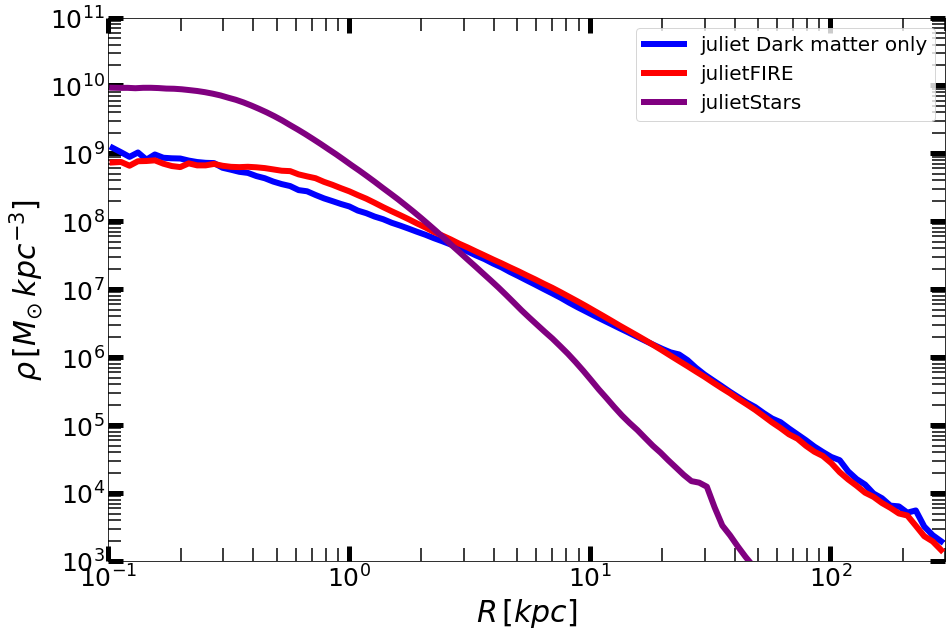

In [445]:
ax_font = 25
txt_font = 30
lw = 4

######################
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R\, [kpc]$', fontsize = 30)
plt.ylabel(r'$\rho\, [M_{\odot}\, kpc^{-3}]$', fontsize = 30)

plt.loglog(dark_radial_bins, Den_dark, linewidth= 6, color = 'Blue',label = str(halo)+' Dark matter only' )
plt.loglog(bary_radial_bins,  Den_bary  ,  linewidth= 6, color = 'Red', label = str(halo)+''+'FIRE' )
plt.loglog(star_radial_bins,  Den_star  ,  linewidth= 6, color = 'Purple', label = str(halo)+''+'Stars' )





np.save(path+"/"+'density_dark_un_norm'+str(halo)+'.npy',Den_dark)
np.save(path+"/"+'dark_bins_rho_un_norm'+str(halo)+'.npy',dark_radial_bins)
np.save(path+"/"+'density_bary_un_norm'+str(halo)+'.npy',Den_bary)
np.save(path+"/"+'bary_bins_rho_un_norm'+str(halo)+'.npy',bary_radial_bins)







plt.xlim(    0.1, 300)
plt.ylim(    10**3, 10**11)
plt.legend(fontsize = 20)
plt.savefig(path +'Dark_matter_density.png')
plt.show()

                         
#=====================  3.Plot the data  =====================

# Now Use Interpolation to determine the value at which normalization needs to be done to 

In [446]:
print(np.interp(10000, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))
print(np.interp(0, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))

local_rho_dark = (np.interp(8.3, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))
print (1.e7/local_rho_dark)

mult_dark = 1.e7/local_rho_dark


local_rho_bary = (np.interp(8.3, bary_radial_bins, Den_bary, left= np.max(Den_bary), right= np.min(Den_bary), period=None) )
print(1.e7/local_rho_bary)

mult_bary = 1.e7/local_rho_bary



vel_norm_dark = np.sqrt(mult_dark )

vel_norm_bary = np.sqrt(mult_bary )

vel_norm_stars = np.sqrt(mult_bary)


1957.373368605089
1206706467.6914222
1.6020753057749917
1.3135630772519313


In [447]:
pos_x_dark,pos_y_dark,pos_z_dark,radius_dark,dm_mass_dark_final,velocities_dark_final,dm_only_mass = make_coords(dark_coords,dm_mass_dark,velocities_dark,mult_dark)

pos_x_bary,pos_y_bary,pos_z_bary,radius_bary,dm_mass_bary_final,velocities_bary_final,dm_bary_mass = make_coords(bary_coords,dm_mass_bary,velocities_bary,mult_bary)


dm_mass_dark_final = np.asarray(dm_mass_dark_final)
dm_mass_bary_final = np.asarray(dm_mass_bary_final)

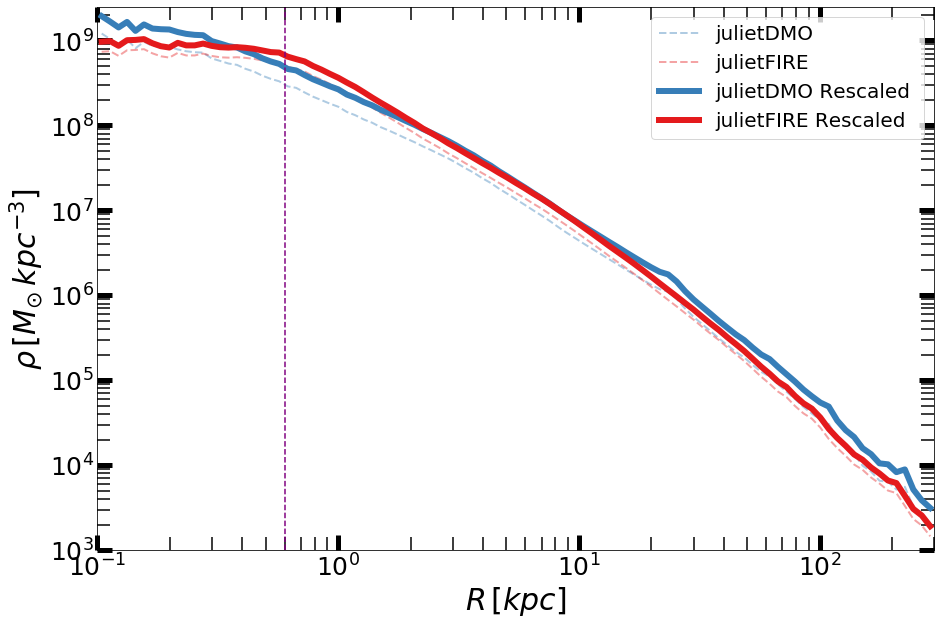

In [448]:
from operator import truediv
my_bins = 100


binning_dark = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
binning_bary = np.logspace(np.log10(0.1),np.log10(300.), my_bins)


dark_radial_bins_new, Den_dark_new = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 300 )
bary_radial_bins_new, Den_bary_new = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 300 )





CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']




ax_font = 25
txt_font = 30
lw = 4

######################
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R\, [kpc]$', fontsize = 30)
plt.ylabel(r'$\rho\, [M_{\odot}\, kpc^{-3}]$', fontsize = 30)
plt.loglog(dark_radial_bins, Den_dark, linewidth= 2,linestyle='--', alpha =0.4 ,color =  CB_color_cycle[0],label = str(halo)+'DMO ' )
plt.loglog(bary_radial_bins,  Den_bary  ,  linewidth= 2,linestyle='--', alpha = 0.4,color =  CB_color_cycle[7], label = str(halo)+''+'FIRE' )

plt.loglog(dark_radial_bins_new, Den_dark_new, linewidth= 6, color =  CB_color_cycle[0],label = str(halo)+'DMO Rescaled ' )
plt.loglog(bary_radial_bins_new,  Den_bary_new  ,  linewidth= 6, color =  CB_color_cycle[7], label = str(halo)+''+'FIRE Rescaled' )



np.save(path+"/"+'density_dark'+str(halo)+'.npy',Den_dark_new)
np.save(path+"/"+'dark_bins_rho'+str(halo)+'.npy',dark_radial_bins_new)
np.save(path+"/"+'density_bary'+str(halo)+'.npy',Den_bary_new)
np.save(path+"/"+'bary_bins_rho'+str(halo)+'.npy',bary_radial_bins_new)






#plt.loglog(rad,rho_test,color = 'orange', linestyle='--', linewidth=3, label = ' NFW')
plt.axvline(x= .6, color = 'purple',linestyle='--')
#plt.axvline(x= 8.3, color = 'orange',linestyle='--')

plt.xlim(    0.1, 300)
plt.ylim(    10**3, 10**9.4)
plt.legend(fontsize = 20)
plt.savefig(path +'Dark_matter_density'+str(halo)+'.png',   bbox_inches='tight' )
plt.show()

                         
#=====================  3.Plot the data  =====================

In [449]:


v_av_dark,radial_bins_dark,dispersion_dark_basic, vx_dark, vy_dark,vz_dark = make_velocities(velocities_dark_final,radius_dark,binning_dark,vel_norm_dark)

v_av_bary,radial_bins_bary,dispersion_bary_basic, vx_bary, vy_bary,vz_bary = make_velocities(velocities_bary_final,radius_bary,binning_bary,vel_norm_bary)

v_av_stars,radial_bins_stars, dispersion_star_basic, vx_stars, vy_stars,vz_stars = make_velocities(velocities_stars,radius_stars,binning_stars,vel_norm_stars)



In [450]:
print(len(velocities_dark_final))
print(len(velocities_bary_final))


48829472
48965340


In [451]:
print(len(dm_mass_dark_final))
print(len(dm_mass_bary_final))

print(dm_only_mass)
print(dm_bary_mass)

#binning_dark = np.arange(0,300,0.5)
#binning_bary = np.arange(0, 300,0.5)
# Old binning above


v_av_dark_un_norm,radial_bins_dark_un_norm,dispersion_dark_basic_un_norm,vx_dark_un_norm, vy_dark_un_norm,vz_dark_un_norm = make_velocities(velocities_dark_final,radius_dark,binning_dark,1.0)

v_av_bary_un_norm,radial_bins_bary_un_norm,dispersion_bary_basic_un_norm , vx_bary_un_norm, vy_bary_un_norm, vz_bary_un_norm = make_velocities(velocities_bary_final,radius_bary,binning_bary,1.0)

48829472
48965340
36451.31685148373
25259.273167914565


402.87789948032423


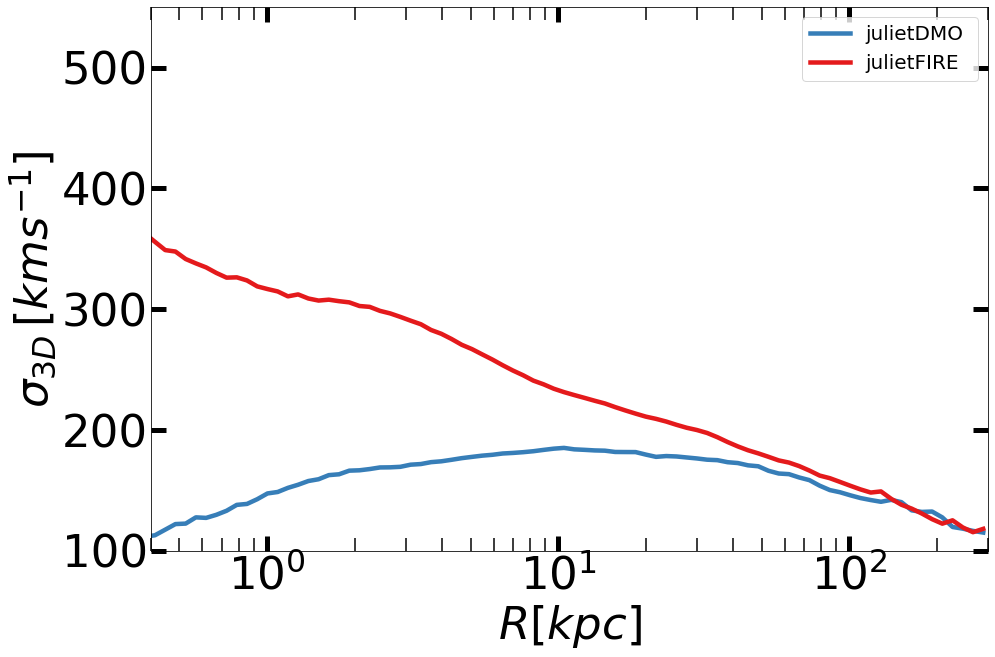

In [452]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']



ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R [kpc]$',  fontsize = ax_font)
plt.ylabel(r'$\sigma_{3D}\, [ km s^{-1}]$',  fontsize = ax_font)


plt.semilogx(radial_bins_dark_un_norm, dispersion_dark_basic_un_norm, linewidth= 4.5, color = CB_color_cycle[0],label = str(halo)+ 'DMO ')

plt.semilogx(radial_bins_bary_un_norm, dispersion_bary_basic_un_norm, linewidth= 4.5, color = CB_color_cycle[7],label = str(halo)+ 'FIRE' )


ax.legend(loc=0, fontsize = 20)

plt.xlim(    0.4, 300.)
plt.ylim(    100, 550.0)



np.save(path+"/"+'disp_dark_un_norm'+str(halo)+'.npy',dispersion_dark_basic_un_norm)
np.save(path+"/"+'dark_bins_vel_disp_un_norm'+str(halo)+'.npy',radial_bins_dark_un_norm)

np.save(path+"/"+'disp_bary_un_norm'+str(halo)+'.npy',dispersion_bary_basic_un_norm)
np.save(path+"/"+'bary_bins_vel_disp_un_norm'+str(halo)+'.npy',radial_bins_bary_un_norm)







plt.savefig(path +'Velocity_dispersion_un_norm'+str(halo)+'.png', bbox_inches='tight')
#plt.title( r'$\sigma $' + ' ' + str(halo)+ ' '+ 'DMO vs.FIRE', fontsize = 40)                                                                                                                                                                 
#plt.xlabel(r'$Radius\, [kpc]$', fontsize = 30)

#plt.ylabel(r'$\sigma_{disp}\, [ km s^{-1}]$')

print(np.max(dispersion_bary_basic_un_norm ))


# Here we use the dispersions that will be used to find the velocity dispersions estimate for nans later on 

461.7415009383701


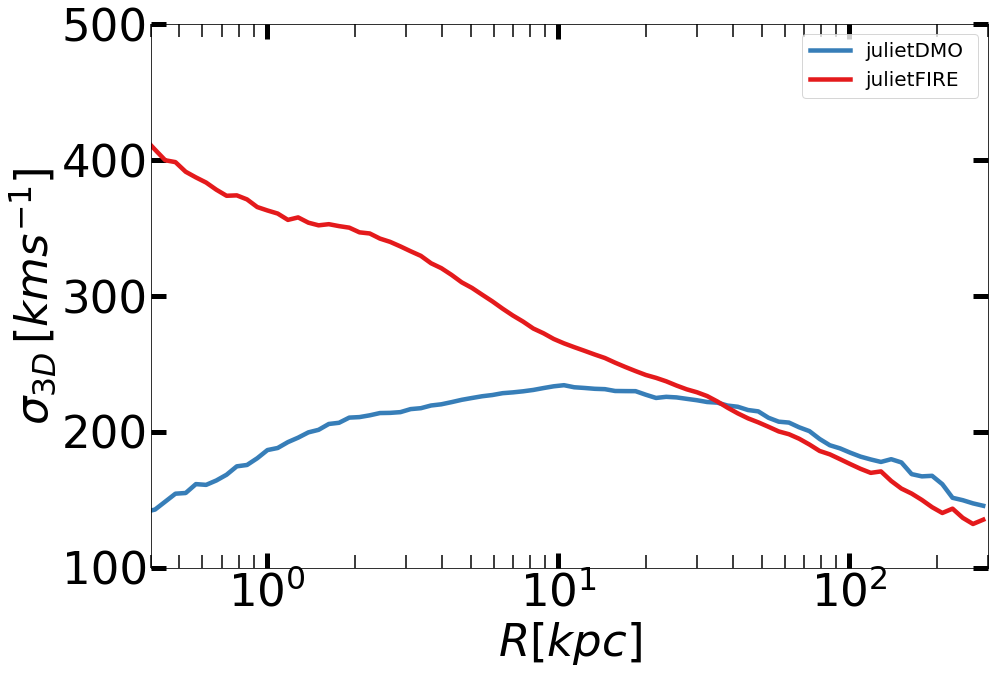

In [453]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']



ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R [kpc]$',  fontsize = ax_font)
plt.ylabel(r'$\sigma_{3D}\, [ km s^{-1}]$',  fontsize = ax_font)


plt.semilogx(radial_bins_dark, dispersion_dark_basic, linewidth= 4.5, color = CB_color_cycle[0],label = str(halo)+ 'DMO ')

plt.semilogx(radial_bins_bary, dispersion_bary_basic, linewidth= 4.5, color = CB_color_cycle[7],label = str(halo)+ 'FIRE' )


ax.legend(loc=0, fontsize = 20)

plt.xlim(    0.4, 300)
plt.ylim(    100., 500.)


np.save(path+"/"+'disp_dark'+str(halo)+'.npy',dispersion_dark_basic)
np.save(path+"/"+'dark_bins_vel_disp'+str(halo)+'.npy',radial_bins_dark)

np.save(path+"/"+'disp_bary'+str(halo)+'.npy',dispersion_bary_basic)
np.save(path+"/"+'bary_bins_vel_disp'+str(halo)+'.npy',radial_bins_bary)




plt.savefig(path +'Velocity_dispersion'+str(halo)+'.png', bbox_inches='tight')
#plt.title( r'$\sigma $' + ' ' + str(halo)+ ' '+ 'DMO vs.FIRE', fontsize = 40)                                                                                                                                                                 
#plt.xlabel(r'$Radius\, [kpc]$', fontsize = 30)

#plt.ylabel(r'$\sigma_{disp}\, [ km s^{-1}]$')

print(np.max(dispersion_bary_basic ))


#  Find the velocity Dispersion weighting the old fashioned way 

# 13   (p wave)

In [454]:
def local_velocity_disp_weighting_p(file_name, radius, bin_edges, dispersion_sq):
    vel_disp_local_p = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_sq)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_p = (np.interp(radius[i] , bin_edges, dispersion_sq, left= dispersion_sq[0] , right= dispersion_sq[final_value], period=None))
        #print(local_vel_p)
        local_vel_p = ((local_vel_p) /( 2.99792458e5)**2 )        
        #print(local_vel_p)
        vel_disp_local_p.insert( i, local_vel_p )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_p)
    return vel_disp_local_p
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

# 14   (d wave)

In [455]:
def local_velocity_disp_weighting_d(file_name, radius, bin_edges, dispersion_fourth):
    vel_disp_local_d = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_fourth)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_d = (np.interp(radius[i] , bin_edges, dispersion_fourth, left= dispersion_fourth[0] , right= dispersion_fourth[final_value], period=None))
        #print(local_vel_p)
        local_vel_d = ((local_vel_d) /( 2.99792458e5)**4 )        
        #print(local_vel_p)
        vel_disp_local_d.insert( i, local_vel_d )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_d)
    return vel_disp_local_d
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

#    Now Finding the local density and Local Velocity Dispersion

# This is needed for advanced local weighting !!!!!

# Start with local weighting for stars

# Use old method

In [456]:
def local_density_weighting(file_name, radius, bin_edges,Den):

    rho_local = []
    #file_name = "rho_local_dm_m12i_new.npy"

    for i in range(len(radius)):

        local_d = (np.interp(radius[i] , bin_edges, Den, left= np.max(Den), right = np.min(Den), period=None))
        rho_local.insert( i, local_d )

    np.save(path+"/"+file_name+'.npy',rho_local)
    return rho_local
    

In [457]:
star_file_name = '/rho_star_only_s_wave_'+str(halo)

rho_local_stars = local_density_weighting(star_file_name, radius_stars, star_radial_bins,Den_star)



In [458]:
rho_local_times_mass_stars = star_mass_final * rho_local_stars

In [459]:
rho_local_times_mass_stars  =  np.asarray(rho_local_times_mass_stars )
print(len(rho_local_times_mass_dm_only))






48829472


In [460]:
plot_bins = 180



rho_local_times_mass_stars  = ( rho_local_times_mass_dm_only * conversion ) 

In [461]:
Phi_stars,Theta_stars,radius_stars,  Angle_weighting_stars ,Cos_Psi_dark_stars = coord_trans( pos_x_stars ,pos_y_stars ,pos_z_stars,d, rho_local_times_mass_stars )


Angle_weighting_stars_conv = Angle_weighting_stars / ( 4.0 * np.pi/  ( plot_bins * plot_bins)) 


# Careful! Don't do the conversion twice !!!!!!!



Theta_deg_stars, Phi_deg_stars  =  Angle_convert( Theta_stars,Phi_stars)

ValueError: operands could not be broadcast together with shapes (48829472,) (15590976,) 

In [ ]:

# tested  for 0,180
plot_bins = 180

#r'$R\, [kpc]$'


title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    


run_type = 'stars'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'stars'


x_bin,y_bin = hammer_projection(Phi_deg_stars, Theta_deg_stars ,Angle_weighting_stars_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.plasma,title,x_lim,y_lim,run_type, wave_type  )


# Old Style

In [ ]:
def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-180.,180.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-90.,90.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)

    print(len(img))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)

    print(np.max(img))
    print(np.median(img))
    print(np.percentile(img, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat

    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
        
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
    cax.get_xaxis().set_visible(True)
    ax.set_xlim([180.,-180.])
    ax.set_ylim([-90.,90.])
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    return xbins,ybins



In [ ]:

# tested  for 0,180
plot_bins = 180

#r'$R\, [kpc]$'


title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    


run_type = 'stars'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'stars'


x_bin,y_bin = hammer_projection(Phi_deg_stars, Theta_deg_stars ,Angle_weighting_stars_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.plasma,title,x_lim,y_lim,run_type, wave_type  )


In [409]:

#J_factor_dark_sum_s
smoothing_length_stars, v_disp_stars,v_mag_stars = get_particle_hsml( pos_x_stars,  pos_y_stars,  pos_z_stars, vx_stars, vy_stars, vz_stars )



volumes_star = (4./3.) * np.pi * (smoothing_length_stars)**3


masses_stars = 32. * star_mass_final


rho_stars = masses_stars/volumes_star



np.save(path+"/"+'full_density_s_stars_'+str(halo)+'.npy',rho_stars)
 
    
np.save(path+"/"+'full_disp_s_stars_'+str(halo)+'.npy',v_disp_stars)


NameError: name 'mass_stars_final' is not defined

In [ ]:
smoothing_length_dark, v_disp_dark, v_mag_dark = get_particle_hsml( pos_x_dark,  pos_y_dark,  pos_z_dark, vx_dark, vy_dark, vz_dark )



volumes_d = (4./3.) * np.pi * (smoothing_length_dark)**3


masses_d = 32. * dm_mass_dark_final


rho = masses_d/volumes_d



np.save(path+"/"+'full_density_s_dark_'+str(halo)+'.npy',rho)
 
    
np.save(path+"/"+'full_disp_s_dark_'+str(halo)+'.npy',v_disp_dark)




In [ ]:


np.save(path+"/"+'full_mag_s_dark_'+str(halo)+'.npy',v_mag_dark)
print(np.min(v_disp_dark))

print(np.sum(v_mag_dark))

In [ ]:



print(np.average((v_disp_dark)))

print(np.average(v_mag_dark))

print(np.max(v_disp_dark))

print(np.max(v_mag_dark))

print(v_mag_dark[5])
print(v_disp_dark[5])
print(np.max(v_mag_dark))
print(np.max(v_disp_dark))

In [ ]:
###############################################

#J_factor_dark_sum_s
smoothing_length_bary, v_disp_bary,v_mag_bary = get_particle_hsml( pos_x_bary,  pos_y_bary,  pos_z_bary, vx_bary, vy_bary, vz_bary )



volumes_b = (4./3.) * np.pi * (smoothing_length_bary)**3


masses_b = 32. * dm_mass_bary_final


rho_b = masses_b/volumes_b



np.save(path+"/"+'full_density_s_bary_'+str(halo)+'.npy',rho_b)
 
    
np.save(path+"/"+'full_disp_s_bary_'+str(halo)+'.npy',v_disp_bary)



In [ ]:


np.save(path+"/"+'full_mag_s_bary_'+str(halo)+'.npy',v_mag_bary)

In [ ]:


print(np.average((v_disp_bary)))

print(np.average(v_mag_bary))

# Load Files 

In [462]:
v_disp_dark =  np.load(path+"/"+'full_disp_s_dark_'+str(halo)+'.npy')
v_mag_dark = np.load(path+"/"+'full_mag_s_dark_'+str(halo)+'.npy')
rho = np.load(path+"/"+'full_density_s_dark_'+str(halo)+'.npy')

v_disp_bary =  np.load(path+"/"+'full_disp_s_bary_'+str(halo)+'.npy')
v_mag_bary = np.load(path+"/"+'full_mag_s_bary_'+str(halo)+'.npy')

rho_b = np.load(path+"/"+'full_density_s_bary_'+str(halo)+'.npy')


In [463]:
#list1 = [10, -21, 4, -45, 66, -93, 1]
  
pos_count, neg_count = 0, 0
  
# iterating each number in list
for num in v_mag_dark:
      
    # checking condition
    if num >= 0:
        pos_count += 1
  
    else:
        neg_count += 1
          
print("Positive numbers in the list: ", pos_count)
print("Negative numbers in the list: ", neg_count)

Positive numbers in the list:  48829472
Negative numbers in the list:  0


In [464]:
print(np.average( v_mag_bary))
print(np.average(v_disp_bary))

183.10632
145.04971


In [465]:
print(len(rho))
print(rho[0])
rho_squared_new = (rho)**2

print(rho_squared_new[0])

print(rho[0]**2)

48829472
1958689.7985333125
3836465726878.4683
3836465726878.4683


# Make a map of the density along the line of sight

In [466]:

Phi_dark_s_new,Theta_dark_s_new,radius_dark_s_new,rho_squared_new ,Cos_Psi_dark_s =  coord_trans_new(pos_x_dark ,pos_y_dark ,pos_z_dark,d,rho_squared_new)
                                                                                                    






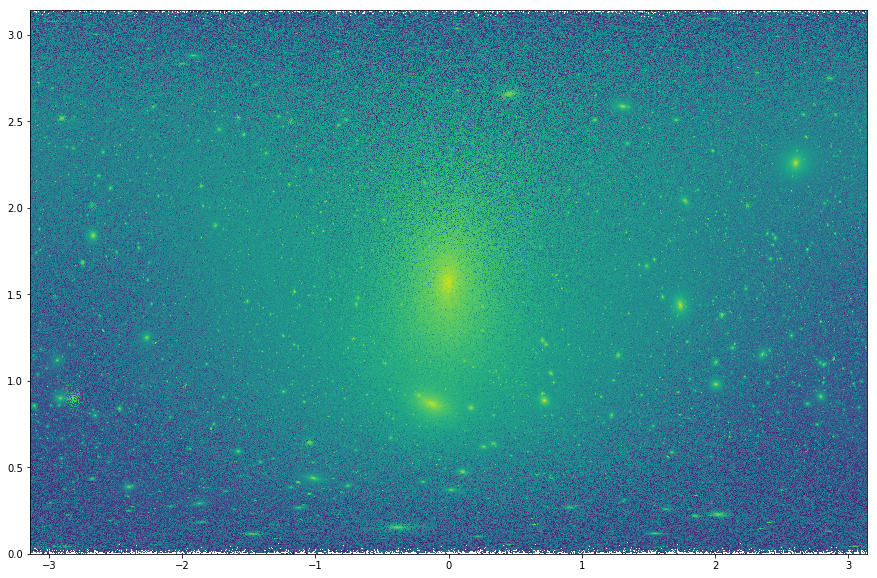

In [467]:
fig, ax = plt.subplots(figsize=(15,10))

plt.hist2d( Phi_dark_s_new,Theta_dark_s_new, norm=mpl.colors.LogNorm(),  weights = (rho_squared_new),   bins= 3000)


plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-149.79115895, -148.79559935, -147.80003975, -146.80448014,
        -145.80892054, -144.81336094, -143.81780133, -142.82224173,
        -141.82668212, -140.83112252, -139.83556292, -138.84000331,
        -137.84444371, -136.8488841 , -135.8533245 , -134.8577649 ,
        -133.86220529, -132.86664569, -131.87108608, -130.87552648,
        -129.87996688, -128.88440727, -127.88884767, -126.89328807,
        -125.89772846, -124.90216886, -123.90660925, -122.91104965,
        -121.91549005, -120.91993044, -119.92437084, -118.92881123,
        -117.93325163, -116.93769203, -115.94213242, -114.94657282,
        -113.95101322, -112.95545361, -111.95989401, -110.9643344 ,
        -109.9687748 , -108.9732152 , -107.97765559, -106.98209599,
   

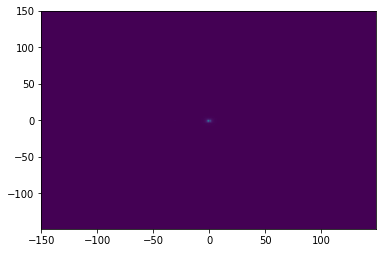

In [468]:
plt.hist2d(star_coords[:,0],star_coords[:,1] ,bins= 300)

In [469]:
rad = 1
x = star_coords[:,0]
y = star_coords[:,1]
z = star_coords[:,2]  
            
radius = np.sqrt(x*x + y*y  + z*z  )

mask = radius <= rad
star_coords = star_coords[mask]


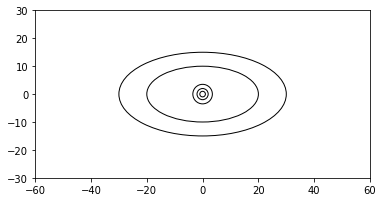

In [470]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse


angle_step = 45  # degrees
angles = np.arange(0, 180, angle_step)

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})



ellipse = Ellipse((0, 0), 2, 2,fill=False)
ellipse1 = Ellipse((0, 0), 4, 4,fill=False)
ellipse2 = Ellipse((0, 0), 7, 7,fill=False)
ellipse3 = Ellipse((0, 0), 40, 20,fill=False)
ellipse4 = Ellipse((0, 0), 60, 30,fill=False, color = 'black')
ellipse5 = Ellipse((0, 0), 70, 40,fill=False, color = 'black')




ax.add_artist(ellipse)
ax.add_artist(ellipse1)
ax.add_artist(ellipse2)
ax.add_artist(ellipse3)
ax.add_artist(ellipse4)






ax.set_xlim(-60., 60.)
ax.set_ylim(-30., 30.)

plt.show()


# Find the Nans

In [471]:
print(np.sum(v_disp_dark))
print(np.min(v_mag_dark))
print(len((np.argwhere(np.isnan(v_disp_dark)))))
print(len((np.argwhere(np.isnan(v_mag_dark)))))
ratio = (v_disp_dark/v_mag_dark)
print(np.min(ratio))


6221024000.0
1.2752694
0
0
0.17965822



# Dark only nans is an array of indices that are nans. Use this array of indices to act on the density array before multiplying to get the Local J factor. 

In [472]:
dark_only_nans = (np.argwhere(np.isnan(v_disp_dark)))
dark_only_nans = dark_only_nans.flatten()
print(dark_only_nans)

print(len(dark_only_nans))

leftover_radii_D = radius_dark[dark_only_nans]
np.save(path+"/"+'dark_nans_juliet'+'.npy',dark_only_nans)

np.save(path+"/"+'left_over_radii_d_'+str(halo)+'.npy',leftover_radii_D)

print(leftover_radii_D)
print(len(leftover_radii_D))

leftover_rho_dark = rho[dark_only_nans]

np.save(path+"/"+'left_density_d_'+str(halo)+'.npy',leftover_rho_dark)

# Now later on we will use Leftover radii_D to complete the weighting manually ( with interpolation directly)

[]
0
[]
0


# Now load the vel. disp data and local rho so it doesn't have to be run again!


In [473]:
print(len(v_disp_dark))
print(len(v_disp_bary))
#print(len(local_rho_dark))
#print(len(local_rho_bary))


48829472
48965340


In [474]:



bary_only_nans = (np.argwhere(np.isnan(v_disp_bary)))
bary_only_nans = bary_only_nans.flatten()

np.save(path+"/"+'bary_nans_juliet'+'.npy',bary_only_nans)
print(dark_only_nans)

print(len(bary_only_nans))

leftover_radii_B = radius_bary[bary_only_nans]

np.save(path+"/"+'left_over_radii_b_'+str(halo)+'.npy',leftover_radii_B)


leftover_rho_bary = rho_b[bary_only_nans]

np.save(path+"/"+'left_density_b_'+str(halo)+'.npy',leftover_rho_bary)

# Now late


print(leftover_radii_B)
print(len(leftover_radii_B))

# Now later on we will use Leftover radii_D to complete the weighting manually ( with interpolation directly)


[]
0
[]
0


In [475]:
print(len(leftover_rho_bary))
print(len(leftover_rho_dark))

0
0


# Remove Nans from the arrays 

In [476]:
v_disp_dark_F = v_disp_dark[np.logical_not(np.isnan(v_disp_dark))]

In [477]:
v_mag_dark_F = v_mag_dark[np.logical_not(np.isnan(v_disp_dark))]

In [478]:
print (len(v_disp_dark))

print(np.argwhere(np.isnan(v_disp_dark)))

48829472
[]


In [479]:
# Get rid of this for the moment

In [480]:
v_disp_bary_F = v_disp_bary[np.logical_not(np.isnan(v_disp_bary))]

#  J factor values calculated

In [481]:
dispersion_dark_sq = 2.0 * v_disp_dark_F * v_disp_dark_F 

dispersion_bary_sq = 2.0  * v_disp_bary_F * v_disp_bary_F




dispersion_dark_fourth = (48./9.) * (v_disp_dark_F )**4

dispersion_bary_fourth = (  48./9. ) *  (v_disp_bary_F)**4




dispersion_dark_sq_F =  dispersion_dark_sq /(( 2.99792458e5)**2 ) 

dispersion_bary_sq_F = dispersion_bary_sq /(( 2.99792458e5)**2 )



dispersion_dark_fourth_F = dispersion_dark_fourth / (( 2.99792458e5)**4 )

dispersion_bary_fourth_F = dispersion_bary_fourth / (( 2.99792458e5)**4 )


v_mag_dark_converted =  (v_mag_dark)**2 / (( 2.99792458e5)**2 ) 

#### 4p/n^2 weighting is only for the sky map, because the bins in the dJ/dOmega plot are the "rings" of width 2pi*dcos(theta)
#### we are doing rings in the dJ/dO plot, but in the sky map we're doing n^2 squares over 4pi steradians

In [482]:
plot_bins = 100


rho_local_times_mass_dm_only = dm_mass_dark_final * rho

rho_local_times_mass_dm_only_F  = ( rho_local_times_mass_dm_only * conversion ) 



Phi_dark_s,Theta_dark_s,radius_dark_s,  Angle_weighting_dark_new_s ,Cos_Psi_dark_s = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, rho_local_times_mass_dm_only_F )


Angle_weighting_dark_new_s_conv = Angle_weighting_dark_new_s / ( 4.0 * np.pi/  ( plot_bins * plot_bins)) 


# Careful! Don't do the conversion twice !!!!!!!



Theta_deg_dark_array_s, Phi_deg_dark_array_s  =  Angle_convert( Theta_dark_s,Phi_dark_s)





In [483]:





def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-90.,90.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-45.,45.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)
    print( 'len binner') 
    print(len(binner1))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    #plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    
    plot = ax.imshow(img.T,origin='lower',
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat
    #create a figure to plot the histogram on
    
    
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    
    
    #plt.contour (New_band ,colors='k');
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    
    
    ### Comment at.gridlines out 
    #at.gridlines(lz,fig,ax)
        
    #ax.contour (  x_con_d ,y_con_d,J_facts.T, colors = 'k' , levels = 12);
    
    #ax.contour  ( xx_b ,yy_b, hist_b, colors = 'white', levels = 12 );
    
    #ax.contour  ( x_con ,y_con, J_facts_b.T, colors = 'k', levels = 12 );
    #ax.contour(xx_d,yy_d, hist_d,colors = 'white', levels = 12  );
    
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
  #  cax.get_xaxis().set_visible(True)
    #ax.set_xlim([90.,-90.])
    
    ax.set_xlim([-90.,90.])
    
    ax.set_ylim([-45.,45.])
    
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    # return xbins,ybins,img,l,b, Final_weighting
    
    return xbins,ybins,img,l,b, Final_weighting























len binner
100
5.389340902699728e+21
1504846478653481.0
73948067408813.84
19.979458488764145
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
24.365377563908776
printing x and y bins
[[19.97945849 20.6357973  20.5519211  ... 20.56468237 20.69068343
  20.83781311]
 [20.16160397 20.33621451 20.52397628 ... 20.81459906 20.93876044
  20.77757026]
 [20.89897505 20.36357557 20.57298863 ... 21.0183537  20.94090446
  21.02073922]
 ...
 [20.33912256 20.45309186 20.39003762 ... 21.28424004 21.14232238
  20.90835586]
 [20.32146628 20.90831933 20.21894302 ... 20.98731673 20.9442844
  20.79516325]
 [20.45438067 21.34588286 21.13677882 ... 20.93592828 20.93075257
  20.90494902]]


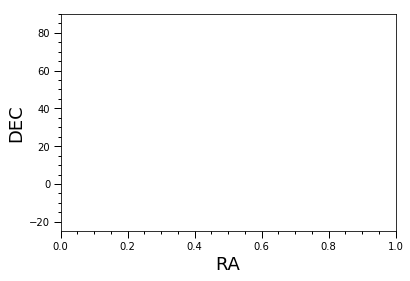

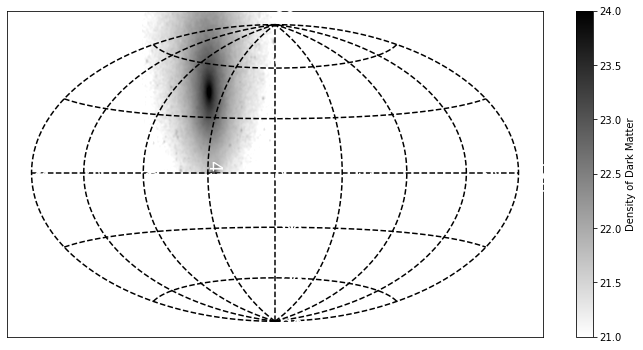

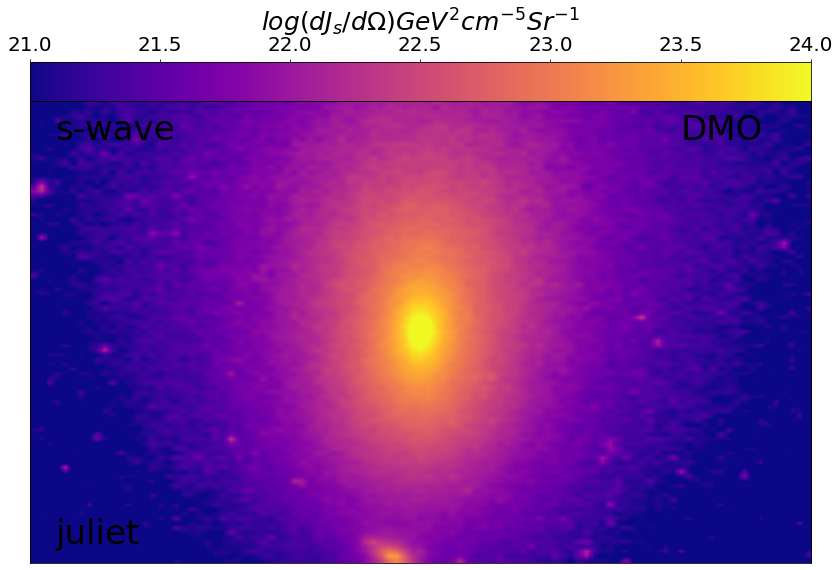

In [484]:
# tested  for 0,180
plot_bins = 100

#r'$R\, [kpc]$'

lower_limit,upper_limit = 21., 24.


title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'DMO'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_dm_only_new_fits'


x_bin,y_bin,J_facts,l_s,b_s, Angle_weighting_dark_new_s_conv = hammer_projection(Phi_deg_dark_array_s, Theta_deg_dark_array_s ,Angle_weighting_dark_new_s_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim, run_type,wave_type)



print(J_facts)

In [485]:
#x_con = np.delete(x_bin_b,0)
#y_con = np.delete(y_bin_b,0)

x_con_d = np.delete(x_bin,0)
y_con_d = np.delete(y_bin,0)

In [486]:



def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-90.,90.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-45.,45.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)
    print( 'len binner') 
    print(len(binner1))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    #plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    
    plot = ax.imshow(img.T,origin='lower',
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat
    #create a figure to plot the histogram on
    
    
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    
    
    #plt.contour (New_band ,colors='k');
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    
    
    ### Comment at.gridlines out 
    #at.gridlines(lz,fig,ax)
        
    ax.contour (  x_con_d ,y_con_d,J_facts.T, colors = 'k' , levels = 12);
    
    #ax.contour  ( xx_b ,yy_b, hist_b, colors = 'white', levels = 12 );
    
    #ax.contour  ( x_con ,y_con, J_facts_b.T, colors = 'k', levels = 12 );
    #ax.contour(xx_d,yy_d, hist_d,colors = 'white', levels = 12  );
    
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
  #  cax.get_xaxis().set_visible(True)
    #ax.set_xlim([90.,-90.])
    
    ax.set_xlim([-90.,90.])
    
    ax.set_ylim([-45.,45.])
    
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    # return xbins,ybins,img,l,b, Final_weighting
    
    return xbins,ybins,img,l,b, Final_weighting







len binner
100
5.389340902699728e+21
1504846478653481.0
73948067408813.84
19.979458488764145
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
24.365377563908776
printing x and y bins
[[19.97945849 20.6357973  20.5519211  ... 20.56468237 20.69068343
  20.83781311]
 [20.16160397 20.33621451 20.52397628 ... 20.81459906 20.93876044
  20.77757026]
 [20.89897505 20.36357557 20.57298863 ... 21.0183537  20.94090446
  21.02073922]
 ...
 [20.33912256 20.45309186 20.39003762 ... 21.28424004 21.14232238
  20.90835586]
 [20.32146628 20.90831933 20.21894302 ... 20.98731673 20.9442844
  20.79516325]
 [20.45438067 21.34588286 21.13677882 ... 20.93592828 20.93075257
  20.90494902]]


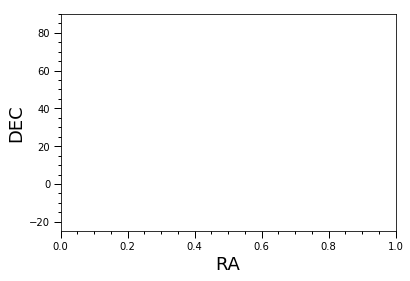

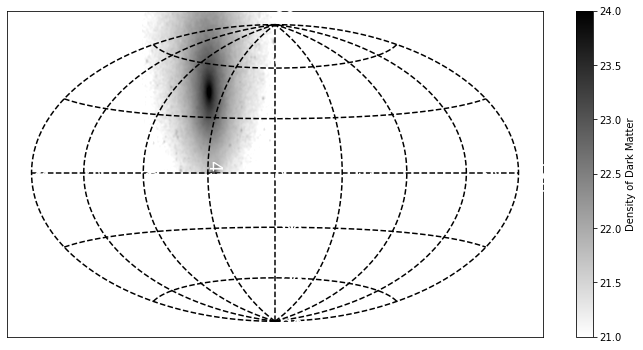

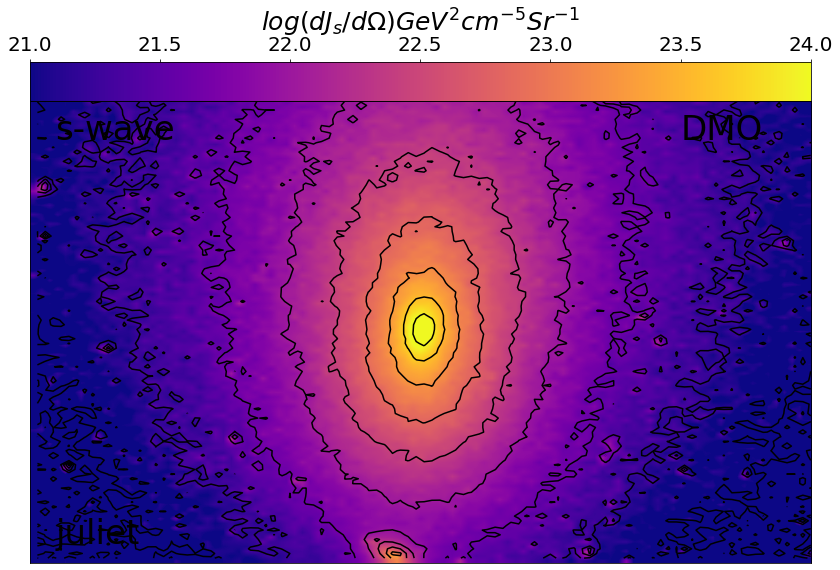

In [487]:
# tested  for 0,180
plot_bins = 100

#r'$R\, [kpc]$'

lower_limit,upper_limit = 21., 24.


title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'DMO'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_dm_only_new_fits'


x_bin,y_bin,J_facts,l_s,b_s, Angle_weighting_dark_new_s_conv = hammer_projection(Phi_deg_dark_array_s, Theta_deg_dark_array_s ,Angle_weighting_dark_new_s_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim, run_type,wave_type)



print(J_facts)





[19.97945849 20.16160397 20.89897505 20.64516889 21.04430104 20.77890234
 20.49817833 20.9870728  20.30985451 20.57035667 20.37793982 20.5325345
 20.6585553  20.58702731 20.74420408 20.82195506 20.86071375 20.76885715
 21.14789024 20.94227478 20.82424112 20.89441233 20.90868972 20.67992543
 21.03071813 21.04800028 21.09080442 20.91065393 20.99124614 21.04891672
 21.13093035 21.1403124  21.2468877  21.26813101 21.22198744 21.24719299
 21.21982414 21.35114793 21.4002183  21.5020098  21.5845596  21.64185289
 21.86287256 22.07260474 22.39374184 22.89495013 23.12406617 22.7120287
 22.29313868 21.98965656 21.78625003 21.63620253 21.58452047 21.71221711
 22.14313114 21.60173671 21.50122261 21.49801927 21.38293335 21.55350811
 21.4482354  21.36005667 21.3986993  21.29470324 21.20914183 21.11308837
 21.22928351 21.17297714 20.96306523 21.23567837 21.10757278 21.03523667
 21.08926778 21.008863   20.96149193 21.76390124 20.9061672  21.01944216
 20.7668751  20.91742727 20.9989034  20.85555024 20.6

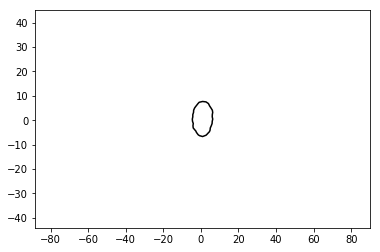

In [523]:
cs = plt.contour (  x_con_d ,y_con_d,J_facts.T,  colors = 'k' , levels = [23.5]);


print ((J_facts.T[0]))
print(x_con_d[0],y_con_d[0])
print(np.max(J_facts.T))


In [524]:
#p = cs.collections[0].get_paths()
#p = cs.collections[0].get_paths()
#p_list = dict(p[0])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
#print(p)
#print(len(x))
#print(len(y))
#print(x[0])




In [490]:
X = x
Y = y
print(X.ndim)

X = X[np.newaxis]
print(X.ndim)
Y = Y[np.newaxis]

1
2


/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


215


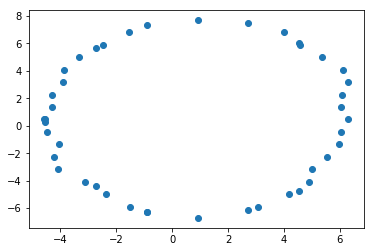

In [498]:
# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()
print(len(x))
# Print the equation of the ellipse in standard form
#print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

# Plot the noisy data
plt.scatter(X, Y, label='Data Points')

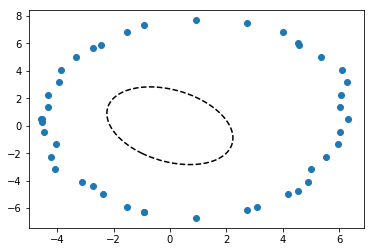

In [506]:
# Plot the noisy data
plt.scatter(X, Y, label='Data Points')

# Plot the original ellipse from which the data was generated
phi = np.linspace(0, 2*np.pi, 1000).reshape((1000,1))
c = np.hstack([np.cos(phi), np.sin(phi)])
ground_truth_ellipse = c.dot(B)
plt.plot(ground_truth_ellipse[:,0], ground_truth_ellipse[:,1], 'k--', label='Generating Ellipse')

# Plot the least squares ellipse
x_coord = np.linspace(-5,5,43)
y_coord = np.linspace(-5,5,43)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('red'), linewidths=2)
plt.show()
#plt.legend()
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.show()


In [525]:
import numpy as np
import matplotlib.pyplot as plt


def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

In [526]:

coeffs = fit_ellipse(x, y)






In [527]:
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)

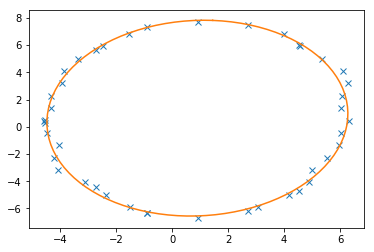

In [528]:
plt.plot(x, y, 'x')     # given points
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
plt.plot(x, y)
plt.show()

Exact parameters:
x0, y0, ap, bp, phi = 4 -3.5 7 3 0.7853981633974483
Fitted parameters:
a, b, c, d, e, f = [ -0.51512181   0.69881946  -0.4962871    6.50098584  -6.24321962
 -16.20202568]
x0, y0, ap, bp, e, phi =  3.911742794301854 -3.5358743361546576 6.953403302434523 2.971316731740818 0.904101232909529 0.7988709928475318


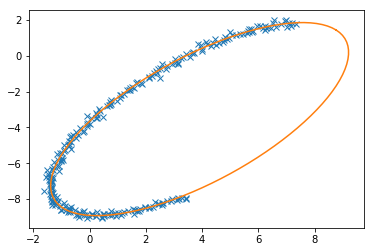

In [507]:
def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y


if __name__ == '__main__':
    # Test the algorithm with an example elliptical arc.
    npts = 250
    tmin, tmax = np.pi/6, 4 * np.pi/3
    x0, y0 = 4, -3.5
    ap, bp = 7, 3
    phi = np.pi / 4
    # Get some points on the ellipse (no need to specify the eccentricity).
    x, y = get_ellipse_pts((x0, y0, ap, bp, None, phi), npts, tmin, tmax)
    noise = 0.1
    x += noise * np.random.normal(size=npts) 
    y += noise * np.random.normal(size=npts)

    coeffs = fit_ellipse(x, y)
    print('Exact parameters:')
    print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
    print('Fitted parameters:')
    print('a, b, c, d, e, f =', coeffs)
    x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
    print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

    plt.plot(x, y, 'x')     # given points
    x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
    plt.plot(x, y)
    plt.show()

In [65]:
#print(((J_facts[0])))
#print((len(x_bin_new)))

np.save(path+"/"+'xbin'+str(halo)+'.npy',x_bin_new)
np.save(path+"/"+'ybin'+str(halo)+'.npy',y_bin_new)
np.save(path+"/"+'Jfacts'+str(halo)+'.npy',J_facts)


#np.save(path+"/"+'xbin'+str(halo)+'.npy',x_bin)
#np.save(path+"/"+'ybin'+str(halo)+'.npy',y_bin)
#np.save(path+"/"+'Jfacts'+str(halo)+'.npy',J_facts)



NameError: name 'x_bin_new' is not defined

In [152]:
q = (Theta_deg_dark_array_s, Phi_deg_dark_array_s)

data = twoD_Gaussian(q, 3, 100, 100, 20, 40, 0, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()

NameError: name 'twoD_Gaussian' is not defined

# Resolution Limit 

In [ ]:
print ( np.degrees (np.arctan( 0.4/8.3)) )

# Baryonic Analysis

## Baryonic Weighting

In [50]:
plot_bins = 180


rho_local_times_mass_dm_bary = dm_mass_bary_final * rho_b

rho_local_times_mass_dm_bary_F  = ( rho_local_times_mass_dm_bary * conversion ) 

        
 

Phi_bary_s_f, Theta_bary_s_f,radius_bary,  Angle_weighting_bary_new_s_f ,Cos_Psi_bary_s_f = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary ,d, rho_local_times_mass_dm_bary_F )


Angle_weighting_bary_new_s_conv_f = Angle_weighting_bary_new_s_f / ( 4.0 * np.pi/  ( plot_bins * plot_bins)) 


# Careful! Don't do the conversion twice !!!!!!!



Theta_deg_bary_array_s_f, Phi_deg_bary_array_s_f  =  Angle_convert( Theta_bary_s_f,Phi_bary_s_f)

In [51]:
print(np.sum(Theta_bary_s_f), np.sum(Phi_bary_s_f))

77588695.04752202 4755170.121121368


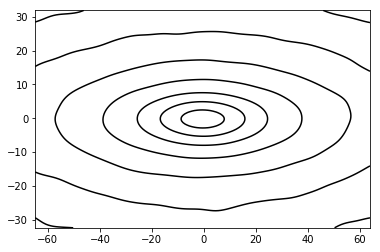

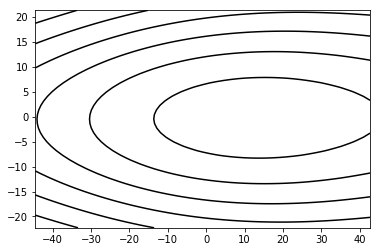

In [68]:

X_lim_b  =  np.load(path+"/"+'x_lim_b'+str(halo)+'.npy')
Y_lim_b  =  np.load(path+"/"+'y_lim_b'+str(halo)+'.npy')
New_band_b = np.load(path+"/"+'band_image_smoothed_lim_b'+str(halo)+'.npy')


plt.contour (X_lim_b,Y_lim_b,New_band_b ,colors='k');



plt.show()

X_lim  =  np.load(path+"/"+'x_lim'+str(halo)+'.npy')
Y_lim  =  np.load(path+"/"+'y_lim'+str(halo)+'.npy')
New_band = np.load(path+"/"+'band_image_smoothed_lim'+str(halo)+'.npy')


plt.contour (X_lim,Y_lim,New_band ,colors='k');

len binner
180
1.7689256046104377e+22
2454680189132514.0
100103547339498.12
19.8494233313474
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
24.141672586644088
printing x and y bins


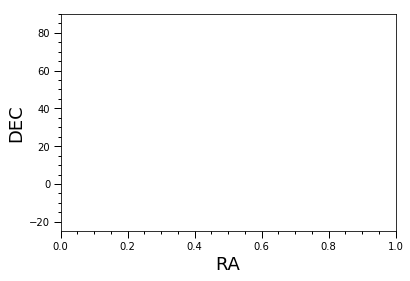

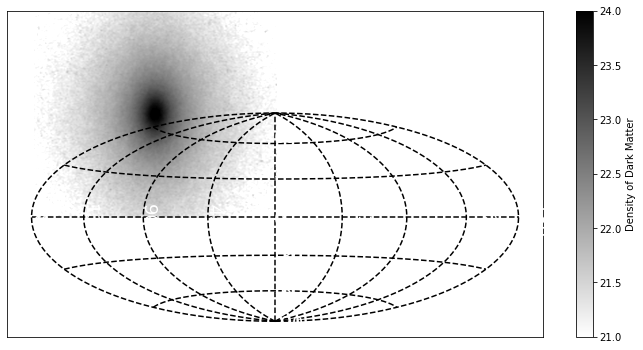

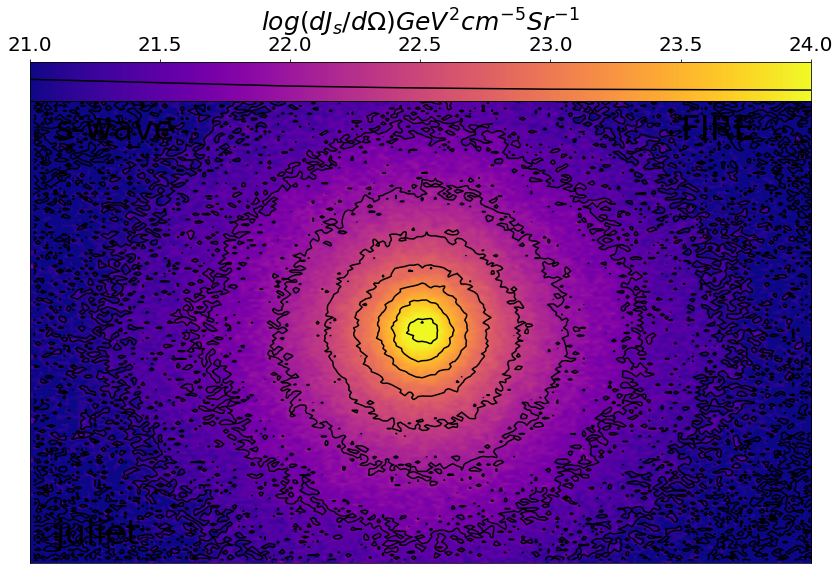

In [440]:
# tested  for 0,180
plot_bins = 180




title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'FIRE'

wave_type = 's-wave'



lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_bary_only_full_f_new'




x_bin_b , y_bin_b, J_facts_b, l_s_b, b_s_b, Angle_weighting_bary_new_s_conv_f = hammer_projection(Phi_deg_bary_array_s_f, Theta_deg_bary_array_s_f ,Angle_weighting_bary_new_s_conv_f , plot_bins,lower_limit ,upper_limit ,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim,run_type, wave_type)


#print(x_bin,y_bin)

#### x_bin_b , y_bin_b, J_facts_b

In [62]:
# tested  for 0,180
plot_bins = 180




title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'FIRE'

wave_type = 's-wave'



lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_bary_only_full_f_new'




x_bin_b , y_bin_b, J_facts_b, l_s_b, b_s_b, Angle_weighting_bary_new_s_conv_f = hammer_projection(Phi_deg_bary_array_s_f, Theta_deg_bary_array_s_f ,Angle_weighting_bary_new_s_conv_f , plot_bins,lower_limit ,upper_limit ,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim,run_type, wave_type)


#print(x_bin,y_bin)

NameError: name 'Phi_deg_bary_array_s_f' is not defined

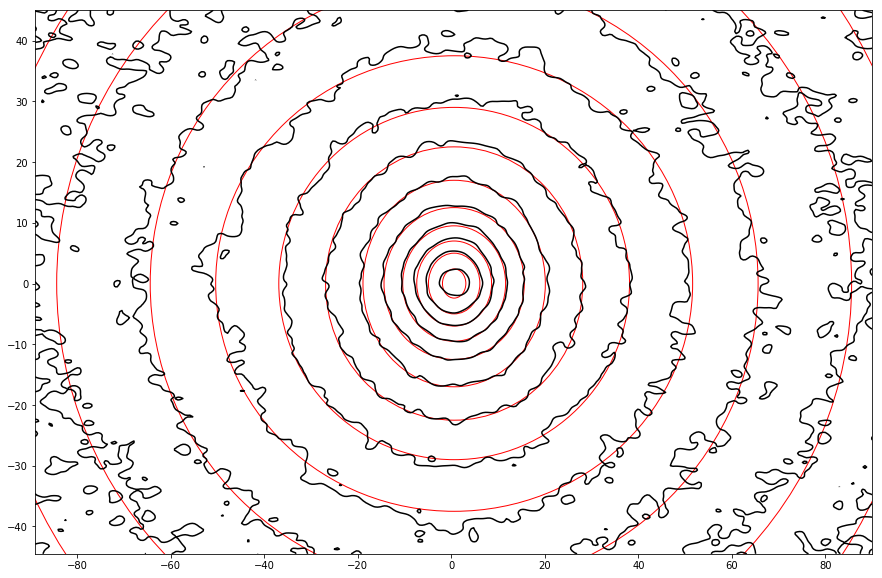

In [520]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse


fig, ax = plt.subplots(figsize=(15,10))


ax.contour  ( xx_b ,yy_b, hist_b, colors = 'k', levels = 12 );
    

    
angle_step = 45  # degrees
angles = np.arange(0, 180, angle_step)


ellipse = Ellipse((0.6, 0), 5, 4.8,fill=False, color = 'red')
ellipse1 = Ellipse((0.6, 0), 11, 10,fill=False, color = 'red')
ellipse2 = Ellipse((0.6, 0), 16, 14,fill=False, color = 'red')
ellipse3 = Ellipse((0.6, 0), 22, 19,fill=False, color = 'red')
ellipse4 = Ellipse((0.6, 0), 30, 25,fill=False, color = 'red')
ellipse5 = Ellipse((0.6, 0), 39, 34,fill=False, color = 'red')
ellipse6 = Ellipse((0.6, 0), 55, 45,fill=False, color = 'red')
ellipse7 = Ellipse((0.6, 0), 75, 58,fill=False, color = 'red')
ellipse8 = Ellipse((0.6, 0), 102, 75,fill=False, color = 'red')
ellipse9 = Ellipse((0.6, 0), 130, 100,fill=False, color = 'red')
ellipse10 = Ellipse((0.6, 0), 170, 130,fill=False, color = 'red')
ellipse11 = Ellipse((0.6, 0), 200, 160,fill=False, color = 'red')




ax.add_artist(ellipse)
ax.add_artist(ellipse1)
ax.add_artist(ellipse2)
ax.add_artist(ellipse3)
ax.add_artist(ellipse4)
ax.add_artist(ellipse5)
ax.add_artist(ellipse6)
ax.add_artist(ellipse7)
ax.add_artist(ellipse8)
ax.add_artist(ellipse9)
ax.add_artist(ellipse10)
ax.add_artist(ellipse11)



plt.show()


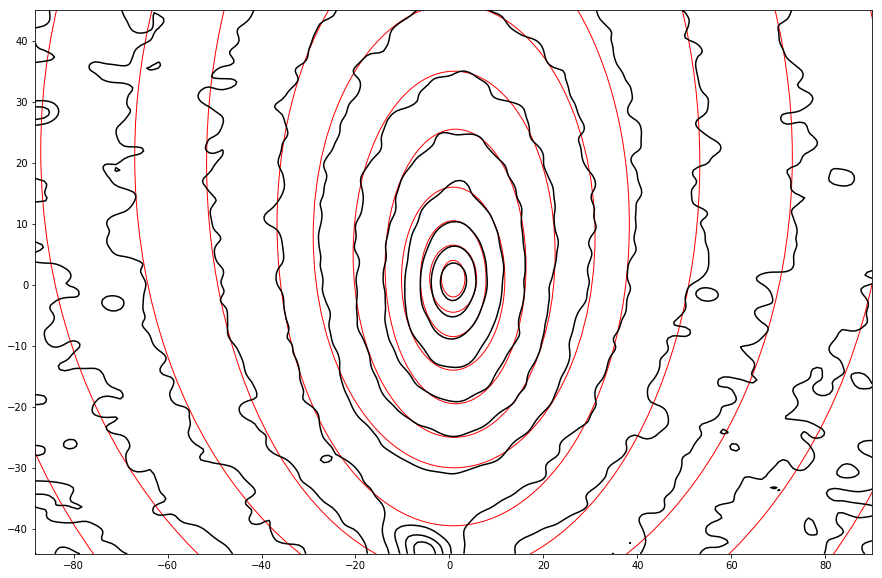

In [587]:

fig, ax = plt.subplots(figsize=(15,10))


ax.contour(xx_d,yy_d, hist_d,colors = 'k', levels = 12  );
 
angle_step = 45  # degrees
angles = np.arange(0, 180, angle_step)


ellipse = Ellipse((0.8, 1), 5, 6,fill=False, color = 'red')
ellipse1 = Ellipse((0.8, 1), 10,11,fill=False, color = 'red')
ellipse2 = Ellipse((0.8, 1), 14, 19,fill=False, color = 'red')
ellipse3 = Ellipse((0.8, 1), 22, 30,fill=False, color = 'red')
ellipse4 = Ellipse((1.3, 3), 30, 45,fill=False, color = 'red')
ellipse5 = Ellipse((1., 5), 43, 60,fill=False, color = 'red')
ellipse6 = Ellipse((1., 8), 60, 76,fill=False, color = 'red')

ellipse7 = Ellipse((0.8, 10), 75, 99,fill=False, color = 'red')
ellipse8 = Ellipse((0.8, 20), 105, 135,fill=False, color = 'red')
ellipse9 = Ellipse((3, 21), 140, 150,fill=False, color = 'red')
ellipse10 = Ellipse((3, 22), 180, 170,fill=False, color = 'red')
ellipse11 = Ellipse((3, 22), 210, 200,fill=False, color = 'red')




ax.add_artist(ellipse)
ax.add_artist(ellipse1)
ax.add_artist(ellipse2)
ax.add_artist(ellipse3)
ax.add_artist(ellipse4)
ax.add_artist(ellipse5)
ax.add_artist(ellipse6)
ax.add_artist(ellipse7)
ax.add_artist(ellipse8)
ax.add_artist(ellipse9)
ax.add_artist(ellipse10)
ax.add_artist(ellipse11)



plt.show()
 
    
    
    
    
    
    
    

# Note distorted shape requires shifting center

In [66]:
import scipy as sp
import scipy.ndimage
upsample = 2
xx_d = sp.ndimage.zoom(x_con_d, upsample)
yy_d = sp.ndimage.zoom(y_con_d, upsample)

hist_d = sp.ndimage.zoom(J_facts.T, upsample)
smooth = 1
smooth *= upsample
#hist = sp.ndimage.gaussian_filter(hist, smooth)
hist_d = sp.ndimage.gaussian_filter(hist_d, smooth)



NameError: name 'x_con_d' is not defined

In [70]:
#plt.contour  ( xx_b ,yy_b, hist_b, levels = 12 );


plt.contour(xx_d,yy_d, hist_d, levels = 12  );

NameError: name 'xx_d' is not defined

NameError: name 'x_bin_b' is not defined

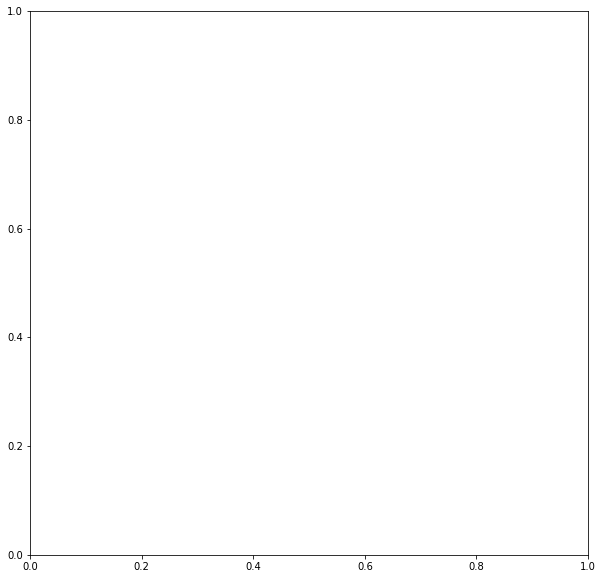

In [71]:



#plt.contour (X_lim,Y_lim,New_band ,colors='k');
fig, ax = plt.subplots(figsize=(10,10))

print(len(x_bin_b) , len(y_bin_b), len(J_facts_b))



x_con = np.delete(x_bin_b,0)
y_con = np.delete(y_bin_b,0)

x_con_d = np.delete(x_bin,0)
y_con_d = np.delete(y_bin,0)

#plt.contour (x_con , y_con, J_facts_b, levels = 12 );

#plt.contour (x_con_d , y_con_d, J_facts, colors = 'k' , levels = 12);


plt.contour  ( x_con ,y_con, J_facts_b.T, levels = 12 );

plt.contour (  x_con_d ,y_con_d,J_facts.T, colors = 'k' , levels = 12);




print(New_band[0])
print(X_lim[0])

print(len(b_s_b))
#plt.contour( Angle_weighting_bary_new_s_conv_f, colors = 'k')


#plt.contour(xx,yy,hist)

#levelsint or array-like, optional
#Determines the number and positions of the contour lines / regions.

#If an int n, use MaxNLocator, which tries to automatically choose no more than n+1 "nice" contour levels between vmin and vmax.

#If array-like, draw contour lines at the specified levels. The values must be in increasing order.

NameError: name 'x_con_d' is not defined

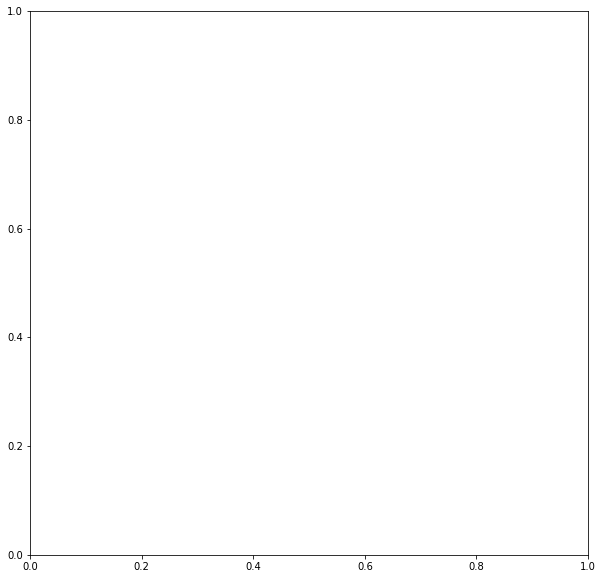

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
path1 =  "/Users/danmckeown/Contoursjuliet.png" 

#plt.contour(x_con_d,y_con_d,J_facts,colors = 'k',levels = 12)

plt.contour(x_con_d,y_con_d,J_facts.T,colors = 'k',levels = 12)

#plt.contour(y_con_d,x_con_d,J_facts, levels = 12)

print(len(hist))


plt.savefig(path +'Contours'+str(halo)+'.png', bbox_inches='tight')

In [73]:
import cv2
path1 =  "/Users/danmckeown/Contoursjuliet.png" 



image = cv2.imread(path1)

window_name = 'Image'


center_coordinates = (0, 0)
  
axesLength = (1, 5)
  
angle = 0
  
startAngle = 0
  
endAngle = 360
   
# Red color in BGR
#color = 'red'
color = (0, 0, 255)
      
# Line thickness of 5 px
thickness = 5
   
# Using cv2.ellipse() method
# Draw a ellipse with red line borders of thickness of 5 px
image = cv2.ellipse(image, center_coordinates, axesLength,
           angle, startAngle, endAngle, color, thickness)
   
# Displaying the image 
cv2.imshow(window_name, image) 




# Test code for contours

In [132]:



def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-90.,90.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-45.,45.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)
    print( 'len binner') 
    print(len(binner1))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    #plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    
    plot = ax.imshow(img.T,origin='lower',
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat
    #create a figure to plot the histogram on
    
    
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    
    
    #plt.contour (New_band ,colors='k');
    
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    
    
    ### Comment at.gridlines out 
    #at.gridlines(lz,fig,ax)
        
    ax.contour (  x_con_d ,y_con_d,J_facts.T, colors = 'k' , levels = 12);
    
    #ax.contour  ( xx_b ,yy_b, hist_b, colors = 'white', levels = 12 );
    
    #ax.contour  ( x_con ,y_con, J_facts_b.T, colors = 'k', levels = 12 );
    #ax.contour(xx_d,yy_d, hist_d,colors = 'white', levels = 12  );
    
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
  #  cax.get_xaxis().set_visible(True)
    #ax.set_xlim([90.,-90.])
    
    ax.set_xlim([-90.,90.])
    
    ax.set_ylim([-45.,45.])
    
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    # return xbins,ybins,img,l,b, Final_weighting
    
    return xbins,ybins,img,l,b, Final_weighting















In [75]:
#USED to project Aitoff data points and grid lines (assumes input in degrees)
import numpy as np
import matplotlib.pyplot as plt


degrad = np.pi/180.

# THIS IS FROM THE ACTUAL PROGRAM I USE l, b = at.project(Phi_deg_dark_array,Theta_deg_dark_array,lz)


def project(li,bi,lz):
   sa = li-lz

   alpha2 = sa*degrad/2.
   delta = bi*degrad
   
   r2 = np.sqrt(2.)
   f = 2.*r2/np.pi
   
   cdec = np.cos(delta)
   denom = np.sqrt(1.+cdec*np.cos(alpha2))
   
   xx = cdec*np.sin(alpha2)*2.*r2/denom
   yy = np.sin(delta)*r2/denom
   
   xx = xx*(1./degrad)/f
   yy = yy*(1./degrad)/f


   return xx,yy


def project_grid(li,bi):
   
   sa = -(li-180.) #UNCOMENT lz=0
      
   alpha2 = sa*degrad/2.
   delta = bi*degrad  
   r2 = np.sqrt(2.)
   f = 2.*r2/np.pi
   
   cdec = np.cos(delta)
   denom = np.sqrt(1.+cdec*np.cos(alpha2))
   
   xx = cdec*np.sin(alpha2)*2.*r2/denom
   yy = np.sin(delta)*r2/denom
   
   xx = xx*(1./degrad)/f
   yy = yy*(1./degrad)/f
   return xx,yy



def gridlines(lz,fig,ax):


   Lex = np.linspace(0,360,9)
   print(Lex)
   Lex_1 = np.asarray([  180 ,225 , 270, 315, 0, 45, 90, 135, 180])
   Bex = np.linspace(0,180,180)-90.
   Lex1 = np.linspace(0,360,360)
   Bex1 = np.linspace(0,180,7)-90.
   Lgrid,Bgrid = np.meshgrid(Lex,Bex)
   Lgrid1,Bgrid1 = np.meshgrid(Lex1,Bex1)
   X,Y = project_grid(Lgrid,Bgrid)
  
   XX,YY = project_grid(Lgrid1,Bgrid1)
# uncomment for contour plots
   ax.plot(X,Y,'--',color='black')
   ax.plot(XX.T,YY.T,'--',color='black')

   for i in range(len(Lex)):
      if Lex[i] <= lz:
         fitter = X[int(X.shape[0]/2),Lex.size-1-i]-8
      else:
         fitter = X[int(X.shape[0]/2),Lex.size-1-i]+3
      Lex[i] = Lex[i]-180.-lz
      if Lex[i] < 0:
         Lex[i]=Lex[i]+360.
      if Lex[i] != 360.:
   
         ax.text(fitter,0,str(int(Lex_1[i])),fontsize=18,rotation=270,color= 'white')
         print(str(int(Lex[i])))
   for i in range(len(Bex1)):
      if Bex1[i] > 0.:
         fitter = YY[i,int(len(YY[i])/2)]+1
      else:
         fitter = YY[i,int(len(YY[i])/2)]-6
      ax.text(1,fitter,str(int(Bex1[i])),fontsize=18, color = 'white')
   fig.gca().get_xaxis().set_visible(False)
   fig.gca().get_yaxis().set_visible(False)





def air_plot(Lex,Bex,Lex1,Bex1,X,Y,XX,YY,lz):

   plt.plot(X,Y,color='black')
   plt.plot(XX.T,YY.T,color='black')


   #GRID LABELS

   for i in range(len(Lex)):
      if Lex[i] <= lz:
         fitter = XX[i]-8
      else:
         fitter = XX[i]+3
      if Lex[i] < 0:
         Lex[i]=Lex[i]+360
      if Lex[i] != 360.:
   
         plt.text(fitter,0,str(int(Lex[i])),fontsize=12,rotation=90)
   
   for i in range(len(Bex1)):
      if Bex1[i] > 0.:
         fitter = YY1[i]+1
      else:
         fitter = YY1[i]-6
      plt.text(1,fitter,str(int(Bex1[i])),fontsize=12)
   #END GRID LABELS


In [76]:
print(x_bin_b)
x_bin_new_b = x_bin_b[:-1]
y_bin_new_b = y_bin_b[:-1]

NameError: name 'x_bin_b' is not defined

In [ ]:
np.save(path+"/"+'xbin_b'+str(halo)+'.npy',x_bin_new_b)
np.save(path+"/"+'ybin_b'+str(halo)+'.npy',y_bin_new_b)
np.save(path+"/"+'Jfacts_b'+str(halo)+'.npy',J_facts_b)



# Now interpolate remaining bary radii and combine this vel disp data with Data above to make full weighted array

In [77]:

dispersion_dark_sq = 2.0 * dispersion_dark_basic * dispersion_dark_basic

dispersion_bary_sq = 2.0 * dispersion_bary_basic * dispersion_bary_basic


# Create filename to send 


dm_only_file_name_p_new = '/vel_dm_only_p_wave_leftover'+str(halo)

vel_dm_only_p_wave = local_velocity_disp_weighting_p(dm_only_file_name_p_new, leftover_radii_D,  radial_bins_dark,dispersion_dark_sq)



dark_bary_file_name_p_new = '/vel_bary_p_wave_'+str(halo)

vel_bary_p_wave = local_velocity_disp_weighting_p(dark_bary_file_name_p_new, leftover_radii_B, radial_bins_bary , dispersion_bary_sq)
          

NameError: name 'dispersion_dark_basic' is not defined

In [78]:
print(len(vel_bary_p_wave))
print(len(vel_dm_only_p_wave))





vel_dm_only_p_wave_short = np.asarray(vel_dm_only_p_wave)
vel_bary_p_wave_short = np.asarray(vel_bary_p_wave)
vel_dm_only_p_wave_short_f = vel_dm_only_p_wave_short/(( 2.99792458e5)**2 )
vel_bary_p_wave_short_f = vel_bary_p_wave_short/(( 2.99792458e5)**2 )

NameError: name 'vel_bary_p_wave' is not defined

# Now combine the two velocity disp^2 arrays into one and map it out 

In [79]:
dispersion_dark_sq_Fin = np.asarray(dispersion_dark_sq_F) 

dispersion_bary_sq_Fin = np.asarray(dispersion_bary_sq_F)  


final_dm_p_weight_FINAL = np.concatenate((dispersion_dark_sq_Fin, vel_dm_only_p_wave_short_f))


final_bary_p_weight_FINAL = np.concatenate((dispersion_bary_sq_Fin, vel_bary_p_wave_short_f ))


NameError: name 'vel_dm_only_p_wave_short_f' is not defined

In [ ]:
print(len(vel_dm_only_p_wave_short_f))
print(len(vel_bary_p_wave_short_f))


In [ ]:
print ( np.divide(v_mag_dark_converted    , final_dm_p_weight_FINAL ))

In [ ]:
final_dm_p_weight_F = final_dm_p_weight_FINAL * rho_local_times_mass_dm_only

plot_bins = 180


final_dm_p_weight_Fin = (  final_dm_p_weight_F * conversion ) 



Phi_dark_p,Theta_dark_p,radius_dark_p,Angle_weighting_dark_p,Cos_Psi_dark_p = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_p_weight_Fin )


Angle_weighting_dark_p_conv   =   (Angle_weighting_dark_p)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_dark_array_p, Phi_deg_dark_array_p  =  Angle_convert( Theta_dark_p,Phi_dark_p)



In [ ]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 14.5, 17.5

file_name_of_hammer = 'Hammer_dm_only_p_wave_old'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



    
x_lim = [14.6, 14.6 , 17.0,16.9]

y_lim = [11.7, -18.6, 11.7]

run_type = 'DMO'

wave_type = 'p-wave'

calc = 'Maxwellian'



x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_p,Theta_deg_dark_array_p ,Angle_weighting_dark_p_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

In [ ]:
plot_bins = 180

final_bary_p_weight_F = final_bary_p_weight_FINAL * rho_local_times_mass_dm_bary

plot_bins = 180


final_bary_p_weight_Fin = (  final_bary_p_weight_F * conversion ) 




Phi_bary_p, Theta_bary_p, radius_bary_p, Angle_weighting_bary_p ,Cos_Psi_bary_p = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d,final_bary_p_weight_Fin )



Angle_weighting_bary_p_conv = ( Angle_weighting_bary_p)  /  ( 4. * np.pi  /  ( plot_bins * plot_bins)) 


Theta_deg_bary_array_p, Phi_deg_bary_array_p  =  Angle_convert( Theta_bary_p, Phi_bary_p)


In [ ]:
# tested  for 0,180
plot_bins = 180
title = 'p-wave FIRE' + ''+ ' Log(Js}) Gev^2 cm^-5  Sr^{-1}'
lower_limit,upper_limit = 14.5, 19.5



title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'


x_lim = [14.6, 14.6 , 17.0,16.9]

y_lim = [11.7, -18.6, 11.7]


run_type = 'FIRE'

wave_type = 'p-wave'

calc = 'Maxwellian'


file_name_of_hammer = 'Hammer_bary_p_wave_old'

hammer_projection_new(Phi_deg_bary_array_p,  Theta_deg_bary_array_p,   Angle_weighting_bary_p_conv , plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim, y_lim,run_type , wave_type,calc)



#print(x_bin,y_bin)

# Now find the same for v_mag **2

In [ ]:
v_mag_dark_final_sq = v_mag_dark * v_mag_dark


v_mag_dark_final_sq = (v_mag_dark_final_sq) / (( 2.99792458e5)**2 ) 

In [ ]:
final_dm_p_weight_mag = v_mag_dark_final_sq * rho_local_times_mass_dm_only

plot_bins = 180


final_dm_p_weight_mag_F = (  final_dm_p_weight_mag * conversion ) 



Phi_dark_p_mag,Theta_dark_p_mag,radius_dark_p_mag,Angle_weighting_dark_p_mag,Cos_Psi_dark_p_mag = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_p_weight_mag_F )


Angle_weighting_dark_p_mag_conv   =   (Angle_weighting_dark_p_mag)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_dark_array_p_mag, Phi_deg_dark_array_p_mag  =  Angle_convert( Theta_dark_p_mag,Phi_dark_p_mag)



In [ ]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 14.5, 17.5

file_name_of_hammer = 'Hammer_dm_only_p_wave_old_mag'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



x_lim = [14.6, 14.6 , 17.0,16.9]

y_lim = [11.7, -18.6, 11.7]

run_type = 'DMO'

wave_type = 'p-wave'

calc = ''




x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_p_mag,Theta_deg_dark_array_p_mag ,Angle_weighting_dark_p_mag_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

In [ ]:
v_mag_bary_final_sq = v_mag_bary * v_mag_bary


v_mag_bary_final_sq = (v_mag_bary_final_sq) / (( 2.99792458e5)**2 ) 

In [ ]:
final_bary_p_weight_mag = v_mag_bary_final_sq * rho_local_times_mass_dm_bary

plot_bins = 180


final_bary_p_weight_mag_F = (  final_bary_p_weight_mag * conversion ) 



Phi_bary_p_mag,Theta_bary_p_mag,radius_bary_p_mag,Angle_weighting_bary_p_mag,Cos_Psi_bary_p_mag = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_p_weight_mag_F )


Angle_weighting_bary_p_mag_conv   =   (Angle_weighting_bary_p_mag)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_bary_array_p_mag, Phi_deg_bary_array_p_mag  =  Angle_convert( Theta_bary_p_mag,Phi_bary_p_mag)



In [ ]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 14.5, 17.5

file_name_of_hammer = 'Hammer_bary_p_wave_old_mag'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



x_lim = [14.6, 14.6 , 17.0,16.9]

y_lim = [11.7, -18.6, 11.7]

run_type = 'FIRE'

wave_type = 'p-wave'

calc = ""



x_bin,y_bin = hammer_projection_new(Phi_deg_bary_array_p_mag,Theta_deg_bary_array_p_mag ,Angle_weighting_bary_p_mag_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

# D Weights

In [ ]:

dispersion_dark_4 = (48./9.)* (dispersion_dark_basic)**4 

dispersion_bary_4 = (48./9.)* (dispersion_bary_basic)**4


# Create filename to send 


dm_only_file_name_d_new = '/vel_dm_only_d_wave_leftover'+str(halo)

vel_dm_only_d_wave = local_velocity_disp_weighting_d(dm_only_file_name_d_new, leftover_radii_D,  radial_bins_dark,dispersion_dark_4)



dark_bary_file_name_d_new = '/vel_bary_p_wave_'+str(halo)

vel_bary_d_wave = local_velocity_disp_weighting_d(dark_bary_file_name_d_new, leftover_radii_B, radial_bins_bary , dispersion_bary_4)
          

In [ ]:
print(len(vel_bary_d_wave))
print(len(vel_dm_only_d_wave))





vel_dm_only_d_wave_short_4 = np.asarray(vel_dm_only_d_wave)

vel_bary_d_wave_short_4 = np.asarray(vel_bary_d_wave)

vel_dm_only_d_wave_short_f = vel_dm_only_d_wave_short_4/(( 2.99792458e5)**4 )

vel_bary_d_wave_short_f = vel_bary_d_wave_short_4/(( 2.99792458e5)**4 )

In [ ]:

dispersion_dark_4_Fin = np.asarray(dispersion_dark_fourth_F ) 

dispersion_bary_4_Fin = np.asarray(dispersion_bary_fourth_F )  


final_dm_d_weight_FINAL = np.concatenate((dispersion_dark_4_Fin, vel_dm_only_d_wave_short_f))


final_bary_d_weight_FINAL = np.concatenate((dispersion_bary_4_Fin, vel_bary_d_wave_short_f ))


In [ ]:
final_dm_d_weight  = ( final_dm_d_weight_FINAL *rho_local_times_mass_dm_only)

plot_bins = 180


final_dm_d_weight_Fin = (  final_dm_d_weight * conversion ) 
  



Phi_dark_d, Theta_dark_d, radius_dark_d, Angle_weighting_dark_d, Cos_Psi_dark_d = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_d_weight_Fin )


plot_bins = 180


Angle_weighting_dark_new_d_conv = ( Angle_weighting_dark_d )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_dark_array_d, Phi_deg_dark_array_d  =  Angle_convert( Theta_dark_d , Phi_dark_d)







In [ ]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'





x_lim = [8.6, 8.6 , 11.0,10.9]

y_lim = [6.3, -24.9, 6.3]

run_type = 'DMO'

wave_type = 'd-wave'

calc = "Maxwellian"

lower_limit,upper_limit = 8.5,11.5

file_name_of_hammer = 'hammer_dm_only_'


x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_d , Theta_deg_dark_array_d ,Angle_weighting_dark_new_d_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

In [ ]:
plot_bins = 180

final_bary_d_weight  = ( final_bary_d_weight_FINAL *rho_local_times_mass_dm_bary)


final_bary_d_weight_Fin =  final_bary_d_weight * conversion   

Phi_bary_d,Theta_bary_d,radius_bary_d,Angle_weighting_bary_d,Cos_Psi_bary_d = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_d_weight_Fin )



Angle_weighting_bary_new_d_conv = ( Angle_weighting_bary_d   ) /  ( 4 * np.pi/  ( plot_bins * plot_bins)) 
#Angle_weighting_bary_new_dj_do = ( Angle_weighting_bary * conversion )  # /( 4 * np.pi/  ( plot_bins * plot_bins)) 


Theta_deg_bary_array_d, Phi_deg_bary_array_d  =  Angle_convert( Theta_bary_d, Phi_bary_d )


In [ ]:
# tested  for 0,180
plot_bins = 180
title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'


x_lim = [8.6, 8.6 , 11.0,10.9]

y_lim = [6.3, -24.9, 6.3]

run_type = 'FIRE'

wave_type = 'd-wave'

calc = "Maxwellian"


lower_limit,upper_limit = 8.5, 11.5

file_name_of_hammer = 'hammer_bary_'


hammer_projection_new(Phi_deg_bary_array_d , Theta_deg_bary_array_d ,   Angle_weighting_bary_new_d_conv , plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title, x_lim, y_lim,run_type, wave_type,calc)



#print(x_bin,y_bin)


# Now find the same for v_mag **4

In [ ]:
v_mag_dark_final_4th = (v_mag_dark)**4


v_mag_dark_final_4th = (v_mag_dark_final_4th) / (( 2.99792458e5)**4 ) 

In [ ]:
final_dm_d_weight_mag  = ( v_mag_dark_final_4th *rho_local_times_mass_dm_only)

plot_bins = 180


final_dm_d_weight_Fin_mag = (  final_dm_d_weight_mag * conversion ) 
  



Phi_dark_d_mag, Theta_dark_d_mag, radius_dark_d_mag, Angle_weighting_dark_d_mag, Cos_Psi_dark_d_mag = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_d_weight_Fin_mag )


plot_bins = 180


Angle_weighting_dark_new_d_conv_mag = ( Angle_weighting_dark_d_mag )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_dark_array_d_mag, Phi_deg_dark_array_d_mag  =  Angle_convert( Theta_dark_d_mag , Phi_dark_d_mag)







In [ ]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'





x_lim = [8.6, 8.6 , 11.0,10.9]

y_lim = [6.3, -24.9, 6.3]

run_type = 'DMO'

wave_type = 'd-wave'

calc = ""


lower_limit,upper_limit = 8.5,11.5

file_name_of_hammer = 'hammer_dm_only_mag'


x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_d_mag , Theta_deg_dark_array_d_mag ,Angle_weighting_dark_new_d_conv_mag, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

In [ ]:
v_mag_bary_final_4th = (v_mag_bary)**4


v_mag_bary_final_4th = (v_mag_bary_final_4th) / (( 2.99792458e5)**4 ) 

In [ ]:
final_bary_d_weight_mag  = ( v_mag_bary_final_4th *rho_local_times_mass_dm_bary)

plot_bins = 180


final_bary_d_weight_Fin_mag = (  final_bary_d_weight_mag * conversion ) 
  



Phi_bary_d_mag, Theta_bary_d_mag, radius_bary_d_mag, Angle_weighting_bary_d_mag, Cos_Psi_bary_d_mag = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_d_weight_Fin_mag )


plot_bins = 180


Angle_weighting_bary_new_d_conv_mag = ( Angle_weighting_bary_d_mag )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_bary_array_d_mag, Phi_deg_bary_array_d_mag  =  Angle_convert( Theta_bary_d_mag , Phi_bary_d_mag)







In [ ]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'






x_lim = [8.6, 8.6 , 11.0,10.9]

y_lim = [6.3, -24.9, 6.3]

run_type = 'FIRE'

wave_type = 'd-wave'
calc = ""


lower_limit,upper_limit = 8.5,11.5

file_name_of_hammer = 'hammer_bary_only_mag'


x_bin,y_bin = hammer_projection_new(Phi_deg_bary_array_d_mag , Theta_deg_bary_array_d_mag ,Angle_weighting_bary_new_d_conv_mag, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

# Create J factor Plots for Velocity Independent J factors

# 15).

In [ ]:
# TESTING OLD CODE


J_bins = 35   
sin_bins = np.logspace( -2.0, 0, J_bins)

Cos_Psi_bins = np.sqrt(1. - (sin_bins)**2 )

print(np.max((np.degrees(np.arccos(Cos_Psi_dark_s)))))

Cos_Psi_bins_reverse = Cos_Psi_bins[::-1] 

#print(np.degrees(Cos_Psi_bins_reverse))
# BINNING All coordinates within this range
J_factor , bin_edges_psi = np.histogram(Cos_Psi_dark_s,  bins = Cos_Psi_bins_reverse,  weights = Angle_weighting_dark_new_s)

J_factor_reverse = J_factor[::-1]
print((Cos_Psi_bins_reverse))

print(bin_edges_psi)

print(np.degrees(np.arccos(bin_edges_psi)))

d_theta = np.diff(bin_edges_psi )

J_factor = np.array(J_factor,dtype=float ) 
        
    

J_factor_reverse = np.array(J_factor_reverse,dtype=float ) 

solid_angle = (  np.diff(bin_edges_psi ) * 2.0 * np.pi )


solid_angle_r = solid_angle[::-1]


DJ = (J_factor_reverse / solid_angle_r  )


DJ_DO_bins = (np.degrees(np.arccos(bin_edges_psi)))

DJ_DO_bins_final = DJ_DO_bins[::-1]


DJ_DO_bins_final_final =  (    DJ_DO_bins_final[1:] + DJ_DO_bins_final[:-1]) / 2.0 

In [ ]:
print(np.max(np.degrees(Cos_Psi_dark_s)))
print(len(Cos_Psi_dark_s))

print(len(pos_x_dark))





In [ ]:
def coord_trans( x,y,z,d,weights ):

    x = (x + d)
    
    Phi = np.arctan2(y ,x)
    radius = np.sqrt(( x  )*(  x ) + (y )* (y ) + (z )*(z  ) )        
    u = (z  )  / ( radius )
    Theta = np.arccos(u)
    
    Cos_Psi = (x) /(radius)
    
    a = 0.4
    # a is the softening length.  
    
    Angle_weighting =  ( weights) /  (radius + a)**2    # Weights can either be in terms of rho* density  or rho*density *sigma**2,  or rho* density * sigma**4
    
    
    return Phi,Theta,radius,Angle_weighting,Cos_Psi

In [ ]:






import numpy as np
from astropy.modeling.models import Sersic1D
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(111, xscale='log', yscale='log')
s1 = Sersic1D(amplitude=1, r_eff=5)
r=np.arange(0, 100, .01)

for n in range(1, 10):
     s1.n = n
     plt.plot(r, s1(r), color=str(float(n) / 15))

plt.axis([1e-1, 30, 1e-2, 1e3])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')
plt.text(.25, 1.5, 'n=1')
plt.text(.25, 300, 'n=10')
plt.xticks()
plt.yticks()
plt.show()


In [ ]:
import numpy as np
from astropy.modeling.models import Sersic1D
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(111, xscale='log', yscale='log')
s1 = Sersic1D(amplitude=1, n = 1,r_eff=5)
r_fill =np.arange(0, 100, .01)
x_fill = np.arange(0,100,0.01)
Cos_Psi = x_fill / r_fill

plt.plot(r, s1(r), color=str(float(n) / 15))

plt.axis([1e-1, 30, 1e-2, 1e3])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')

plt.xticks()
plt.yticks()
plt.show()

In [ ]:
print(np.degrees(np.arccos(1 /np.sqrt(3))))
                 

In [ ]:
def J_( Cos_Psi, Final_weights):   
# Cos_Psi is x/r  ( an array of coords)    
    J_bins = 35    

    

    sin_bins = np.logspace( -2.0, 0, J_bins)

    Cos_Psi_bins = np.sqrt(1. - (sin_bins)**2 )


    Cos_Psi_bins_reverse = Cos_Psi_bins[::-1]    
    
    
    #Cos_Psi_bins_reverse = Cos_Psi_bins[::-1]


    J_factor , bin_edges_psi = np.histogram(Cos_Psi,  bins = Cos_Psi_bins_reverse,  weights = Final_weights)
    # Where the particles are, their weights, the bins
    
    print('bin check')
    J_factor_reverse = J_factor[::-1]
    
    print(np.degrees(bin_edges_psi))
    bin_edges_psi_reverse = bin_edges_psi[::-1]
    
    print(Cos_Psi_bins_reverse)
    
    J_factor = np.array(J_factor,dtype=float ) 
        
    
    J_factor_reverse = np.array(J_factor_reverse,dtype=float ) 
    #print('bin edges')
    #print(bin_edges_psi)
    
    bin_edges_psi_final = np.degrees(np.arccos(bin_edges_psi)) 
    
    #bin_edges_psi_final =  bin_edges_psi_final[:-1]
    
    
    bin_edges_psi_final_reverse = bin_edges_psi_final[::-1]
    
    d_theta = np.diff(bin_edges_psi_final_reverse )
    #bin_edges_psi_final_reverse = bin_edges_psi_final_reverse[:-1]
    
    print('printing bins')
    print(bin_edges_psi_final_reverse)
    
    print(len( bin_edges_psi_final  ), len( J_factor))

    J_factor_sum = np.cumsum(J_factor_reverse,axis=0)



    
    return   J_factor, J_factor_reverse,J_factor_sum, bin_edges_psi,bin_edges_psi_reverse, bin_edges_psi_final, bin_edges_psi_final_reverse, d_theta

# 16).

In [ ]:

def J_factor_plots( reverse_dark_bins  ,  reverse_bary_bins,  J_factor_dark_sum, J_factor_bary_sum, x_lim, y_lim, wave_type,y_minimum ,y_maximum  ):
 
  
    ax_font = 45
    txt_font = 45
    lw = 4


    fig, ax = plt.subplots(figsize=(13,13))
    ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

    ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

    plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

    plt.ylabel(r'$J (< \Psi) \, [ GEV ^{2} cm^{-5} ]$', fontsize = 30)
  

    mpl.pyplot.text( x_lim,y_lim, str(halo)+':'+ wave_type , fontsize = 30, color = 'black' )

    #plt.semilogy(degree_same, J_factor_sum,color = 'Blue',linewidth= 6,label = "" )
    plt.semilogy(reverse_dark_bins, J_factor_dark_sum,color =  CB_color_cycle[0],linewidth= 6,label = " DMO " )
    plt.semilogy(reverse_bary_bins, J_factor_bary_sum,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE" )
    plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

    plt.xlim([0,20])
    #plt.ylim ( [10**17 , 10 **25])
    plt.savefig(path +'/J_cumulative'+str(wave_type)+str(halo)+'.png',  bbox_inches='tight' )
    plt.show()



# 17

In [ ]:

def J_factor_plots_new( reverse_dark_bins  ,reverse_dark_bins_mag,  reverse_bary_bins, reverse_bary_bins_mag, J_factor_dark_sum, J_factor_dark_sum_mag  , J_factor_bary_sum, J_factor_bary_sum_mag, x_lim, y_lim, wave_type,y_minimum ,y_maximum  ):
 
  
    ax_font = 45
    txt_font = 45
    lw = 4


    fig, ax = plt.subplots(figsize=(13,13))
    ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

    ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

    plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

    plt.ylabel(r'$J (< \Psi) \, [ GEV ^{2} cm^{-5} ]$', fontsize = 30)
  

    mpl.pyplot.text( x_lim,y_lim, str(halo)+':'+ wave_type , fontsize = 30, color = 'black' )

    #plt.semilogy(degree_same, J_factor_sum,color = 'Blue',linewidth= 6,label = "" )
    plt.semilogy(reverse_dark_bins, J_factor_dark_sum,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian " )
    plt.semilogy(reverse_bary_bins, J_factor_bary_sum,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian" )
    plt.semilogy(reverse_dark_bins_mag, J_factor_dark_sum_mag,color =  CB_color_cycle[0],linewidth= 3,label = " DMO DIRECT ", linestyle='dashed' )
    plt.semilogy(reverse_bary_bins_mag, J_factor_bary_sum_mag,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE DIRECT" , linestyle='dashed')
    
    
    plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

    plt.xlim([0,20])
    #plt.ylim ( [10**17 , 10 **25])
    plt.savefig(path +'/J_cumulative'+str(wave_type)+str(halo)+'.png',  bbox_inches='tight' )
    plt.show()


# 18). 

In [ ]:
def DJ_plots(d_theta,  bin_edges_psi,  J_factor_reverse):

    d_theta_final=   np.radians((d_theta)) 

    print(len((bin_edges_psi_dark )))


    solid_angle = (  np.diff(bin_edges_psi ) * 2.0 * np.pi )


    solid_angle_r = solid_angle[::-1]


    DJ = (J_factor_reverse / solid_angle_r  )


    DJ_DO_bins = (np.degrees(np.arccos(bin_edges_psi)))

    DJ_DO_bins_final = DJ_DO_bins[::-1]


    DJ_DO_bins_final_final =  (    DJ_DO_bins_final[1:] + DJ_DO_bins_final[:-1]) / 2.0 

    return DJ_DO_bins_final_final , DJ 

# 19).

In [ ]:
def DJ_plots_new(d_theta,  bin_edges_psi,  J_factor_reverse):

    d_theta_final=   np.radians((d_theta)) 

    print(len((bin_edges_psi_dark )))


    solid_angle = (  np.diff(bin_edges_psi ) * 2.0 * np.pi )


    solid_angle_r = solid_angle[::-1]


    DJ = (J_factor_reverse / solid_angle_r  )


    DJ_DO_bins = (np.degrees(np.arccos(bin_edges_psi)))

    DJ_DO_bins_final = DJ_DO_bins[::-1]


    DJ_DO_bins_final_final =  (    DJ_DO_bins_final[1:] + DJ_DO_bins_final[:-1]) / 2.0 

    return DJ_DO_bins_final_final , DJ 

# S wave Analysis 

In [ ]:
J_factor_dark,J_factor_dark_reverse, J_factor_dark_sum,bin_edges_psi_dark, bin_edges_psi_reverse_dark, bin_edges_psi_final_dark, bin_edges_psi_final_dark_reverse,d_theta_dark  =  J_( Cos_Psi_dark_s, Angle_weighting_dark_new_s )

print(np.min(Cos_Psi_dark_s))


J_factor_bary, J_factor_bary_reverse, J_factor_bary_sum,bin_edges_psi_bary, bin_edges_psi_reverse_bary, bin_edges_psi_final_bary,bin_edges_psi_final_bary_reverse,d_theta_bary =  J_( Cos_Psi_bary_s_f, Angle_weighting_bary_new_s_f)



In [ ]:
bin_edges_psi_final_dark_reverse_s = bin_edges_psi_final_dark_reverse[:-1]
bin_edges_psi_final_bary_reverse_s = bin_edges_psi_final_bary_reverse[:-1]


y_minimum = 1.0e20 
y_maximum = 5.0e23


x_lim = 14

y_lim = 10**20.2


np.save(path+"/"+'J_factor_dark_sum_s'+str(halo)+'.npy',J_factor_dark_sum)
np.save(path+"/"+'J_factor_bary_sum_s'+str(halo)+'.npy',J_factor_bary_sum)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_s'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_s)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_s'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_s) 
        



wave_type = 's-wave'





print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_s )

print ( J_factor_dark_sum)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_s )


print( J_factor_bary_sum  )


print( J_factor_bary_sum[21])
print(J_factor_dark_sum[21])



J_factor_plots( bin_edges_psi_final_dark_reverse_s, bin_edges_psi_final_bary_reverse_s, J_factor_dark_sum,J_factor_bary_sum,x_lim,y_lim,wave_type,y_minimum ,y_maximum )




In [ ]:
# Need to convert DJ_DO_bins_dark_final_final into radii or need to convert radii into Dj_DO_BINS
print(bin_edges_psi_final_dark_reverse_s)

In [ ]:
DJ_DO_bins_dark_final_final, DJ_dark =   DJ_plots(d_theta_dark ,  bin_edges_psi_dark,  J_factor_dark_reverse)

DJ_DO_bins_bary_final_final, DJ_bary =   DJ_plots(d_theta_bary ,  bin_edges_psi_bary,  J_factor_bary_reverse)

print (DJ_DO_bins_dark_final_final, DJ_dark)




In [ ]:
import numpy as np
from astropy.modeling.models import Sersic1D
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(111, xscale='log', yscale='log')
s1 = Sersic1D(amplitude= 7e23, r_eff= 8,n = 1.6)
r=np.arange(0, 70, .01)



plt.plot(r, s1(r), color= 'black')

In [ ]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.loglog(DJ_DO_bins_dark_final_final, DJ_dark ,color =  CB_color_cycle[0],linewidth= 6,label = " Dark Matter Only " )
plt.loglog(DJ_DO_bins_bary_final_final, DJ_bary  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE" )
plt.plot(r, s1(r), color= 'black', linewidth= 6,label = "Sersic")

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$ dJ/d \Omega (< \Psi) \, [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
  





plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

mpl.pyplot.text( 0.6,10**21.8, str(halo)+': s-wave', fontsize = 30, color = 'black' )

 
mpl.pyplot.ylim( y_minimum, y_maximum )

  
plt.xlim(    0.6,30 )


y_minimum = 2.0e21 
y_maximum = 1.0e25 

mpl.pyplot.ylim( y_minimum, y_maximum )


np.save(path+"/"+'DJ_DO_bins_s_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final)
np.save(path+"/"+'DJ_DO_bins_s_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final)
np.save(path+"/"+'DJ_DO_s_dark'+str(halo)+'.npy',DJ_dark)
np.save(path+"/"+'DJ_DO_s_bary'+str(halo)+'.npy',DJ_bary) 
    



plt.savefig(path +'dJ_DO_'+'SWAVE'+str(halo)+'.png',  bbox_inches='tight')


plt.show()

In [ ]:
import numpy as np
from astropy.modeling.models import Sersic1D
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(111, xscale='log', yscale='log')
s1 = Sersic1D(amplitude= 1e20, r_eff= 300,n = 20)
r=np.arange(0, 300, .01)



plt.plot(r, s1(r), color= 'black')

plt.axis([1e-1, 300, 1e20, 1e25])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')

plt.xticks
plt.yticks
plt.show()


# P wave Analysis 

In [ ]:
J_factor_dark_p ,J_factor_dark_reverse_p, J_factor_dark_sum_p   ,bin_edges_psi_dark_p , bin_edges_psi_reverse_dark_p , bin_edges_psi_final_dark_p  , bin_edges_psi_final_dark_reverse_p , d_theta_dark_p  =  J_( Cos_Psi_dark_p, Angle_weighting_dark_p )

print(np.min(Cos_Psi_dark_p))


J_factor_bary_p, J_factor_bary_reverse_p ,   J_factor_bary_sum_p , bin_edges_psi_bary_p  , bin_edges_psi_reverse_bary_p  ,   bin_edges_psi_final_bary_p  ,  bin_edges_psi_final_bary_reverse_p ,  d_theta_bary_p =  J_(Cos_Psi_bary_p ,  Angle_weighting_bary_p )



#### now for abs velocity versions

In [ ]:
J_factor_dark_p_mag ,J_factor_dark_reverse_p_mag, J_factor_dark_sum_p_mag   ,bin_edges_psi_dark_p_mag , bin_edges_psi_reverse_dark_p_mag , bin_edges_psi_final_dark_p_mag  , bin_edges_psi_final_dark_reverse_p_mag , d_theta_dark_p_mag  =  J_( Cos_Psi_dark_p_mag, Angle_weighting_dark_p_mag )

print(np.min(Cos_Psi_dark_p))


J_factor_bary_p_mag, J_factor_bary_reverse_p_mag ,   J_factor_bary_sum_p_mag , bin_edges_psi_bary_p_mag  , bin_edges_psi_reverse_bary_p_mag  ,   bin_edges_psi_final_bary_p_mag  ,  bin_edges_psi_final_bary_reverse_p_mag ,  d_theta_bary_p_mag =  J_(Cos_Psi_bary_p_mag ,  Angle_weighting_bary_p_mag )



In [ ]:
bin_edges_psi_final_dark_reverse_p_final = bin_edges_psi_final_dark_reverse_p[:-1]
bin_edges_psi_final_bary_reverse_p_final = bin_edges_psi_final_bary_reverse_p[:-1]

### mags below

bin_edges_psi_final_dark_reverse_p_final_mag = bin_edges_psi_final_dark_reverse_p_mag[:-1]
bin_edges_psi_final_bary_reverse_p_final_mag = bin_edges_psi_final_bary_reverse_p_mag[:-1]



np.save(path+"/"+'J_factor_dark_sum_p'+str(halo)+'.npy',J_factor_dark_sum_p)
np.save(path+"/"+'J_factor_bary_sum_p'+str(halo)+'.npy',J_factor_bary_sum_p)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_p'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_p_final)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_p'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_p_final) 
        

    
# mags below

np.save(path+"/"+'J_factor_dark_sum_p_mag'+str(halo)+'.npy',J_factor_dark_sum_p_mag)
np.save(path+"/"+'J_factor_bary_sum_p_mag'+str(halo)+'.npy',J_factor_bary_sum_p_mag)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_p_mag'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_p_final_mag)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_p_mag'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_p_final_mag) 
        


x_lim = 14

y_lim = 10**13.9



wave_type = 'p-wave'


y_minimum = 1.0e13 
y_maximum = 5.0e17

     

print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_p_final )

print ( J_factor_dark_sum_p)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_p_final )


print( J_factor_bary_sum_p  )


print( J_factor_bary_sum_p[21])
print(J_factor_dark_sum_p[21])






J_factor_plots_new( bin_edges_psi_final_dark_reverse_p_final,bin_edges_psi_final_dark_reverse_p_final_mag, bin_edges_psi_final_bary_reverse_p_final,bin_edges_psi_final_bary_reverse_p_final_mag, J_factor_dark_sum_p ,J_factor_dark_sum_p_mag, J_factor_bary_sum_p, J_factor_bary_sum_p_mag, x_lim,y_lim,wave_type,y_minimum,y_maximum )


In [ ]:
DJ_DO_bins_dark_final_final_p, DJ_dark_p =   DJ_plots(d_theta_dark_p ,  bin_edges_psi_dark_p,  J_factor_dark_reverse_p)

DJ_DO_bins_bary_final_final_p, DJ_bary_p =   DJ_plots(d_theta_bary_p ,  bin_edges_psi_bary_p ,  J_factor_bary_reverse_p)


In [ ]:
DJ_DO_bins_dark_final_final_p_mag, DJ_dark_p_mag =   DJ_plots(d_theta_dark_p_mag ,  bin_edges_psi_dark_p_mag,  J_factor_dark_reverse_p_mag)

DJ_DO_bins_bary_final_final_p_mag, DJ_bary_p_mag =   DJ_plots(d_theta_bary_p_mag,  bin_edges_psi_bary_p_mag ,  J_factor_bary_reverse_p_mag)


In [ ]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(13,13))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$dJ/d \Omega  [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
    

plt.loglog(DJ_DO_bins_dark_final_final_p, DJ_dark_p ,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian",  linestyle='dashed' )
plt.loglog(DJ_DO_bins_bary_final_final_p, DJ_bary_p  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian" ,  linestyle='dashed')
# MAG
plt.loglog(DJ_DO_bins_dark_final_final_p_mag, DJ_dark_p_mag ,color =  CB_color_cycle[0],linewidth= 3,label = " DMO Direct" )
plt.loglog(DJ_DO_bins_bary_final_final_p_mag, DJ_bary_p_mag  ,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE Direct" )




plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

mpl.pyplot.text( 1,10**15.9, str(halo)+': p-wave', fontsize = 30, color = 'black' )

y_minimum = 2.0e15
y_maximum = 5.0e19  

plt.xlim(    0.6,60 )
mpl.pyplot.ylim( y_minimum, y_maximum )

        
np.save(path+"/"+'DJ_DO_bins_p_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_p)
np.save(path+"/"+'DJ_DO_bins_p_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_p)
np.save(path+"/"+'DJ_DO_p_dark'+str(halo)+'.npy',DJ_dark_p)
np.save(path+"/"+'DJ_DO_p_bary'+str(halo)+'.npy',DJ_bary_p)
# MAG
np.save(path+"/"+'DJ_DO_bins_p_dark_mag'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_p_mag)
np.save(path+"/"+'DJ_DO_bins_p_bary_mag'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_p_mag)
np.save(path+"/"+'DJ_DO_p_dark_mag'+str(halo)+'.npy',DJ_dark_p_mag)
np.save(path+"/"+'DJ_DO_p_bary_mag'+str(halo)+'.npy',DJ_bary_p_mag)
        
    
plt.savefig(path +'dJ_DO_'+'PWAVE'+str(halo)+'.png',  bbox_inches='tight') 
    
plt.show()

# D Wave Analysis

In [ ]:
J_factor_dark_d ,J_factor_dark_reverse_d, J_factor_dark_sum_d   ,bin_edges_psi_dark_d , bin_edges_psi_reverse_dark_d , bin_edges_psi_final_dark_d  , bin_edges_psi_final_dark_reverse_d , d_theta_dark_d  =  J_( Cos_Psi_dark_d, Angle_weighting_dark_d )

print(np.min(Cos_Psi_dark_d))


J_factor_bary_d, J_factor_bary_reverse_d ,   J_factor_bary_sum_d , bin_edges_psi_bary_d  , bin_edges_psi_reverse_bary_d  ,   bin_edges_psi_final_bary_d  ,  bin_edges_psi_final_bary_reverse_d ,  d_theta_bary_d =  J_(Cos_Psi_bary_d ,  Angle_weighting_bary_d )








### now for abs versions

In [ ]:
J_factor_dark_d_mag ,J_factor_dark_reverse_d_mag, J_factor_dark_sum_d_mag   ,bin_edges_psi_dark_d_mag , bin_edges_psi_reverse_dark_d_mag , bin_edges_psi_final_dark_d_mag  , bin_edges_psi_final_dark_reverse_d_mag , d_theta_dark_d_mag  =  J_( Cos_Psi_dark_d_mag, Angle_weighting_dark_d_mag )

print(np.min(Cos_Psi_dark_d))


J_factor_bary_d_mag, J_factor_bary_reverse_d_mag ,   J_factor_bary_sum_d_mag , bin_edges_psi_bary_d_mag  , bin_edges_psi_reverse_bary_d_mag  ,   bin_edges_psi_final_bary_d_mag  ,  bin_edges_psi_final_bary_reverse_d_mag ,  d_theta_bary_d_mag =  J_(Cos_Psi_bary_d_mag ,  Angle_weighting_bary_d_mag )



In [ ]:
bin_edges_psi_final_dark_reverse_d_final = bin_edges_psi_final_dark_reverse_d[:-1]
bin_edges_psi_final_bary_reverse_d_final = bin_edges_psi_final_bary_reverse_d[:-1]

### mags below

bin_edges_psi_final_dark_reverse_d_final_mag = bin_edges_psi_final_dark_reverse_d_mag[:-1]
bin_edges_psi_final_bary_reverse_d_final_mag = bin_edges_psi_final_bary_reverse_d_mag[:-1]




x_lim = 3

y_lim = 10**8.3

wave_type = 'd-wave'


y_minimum = 1.0e8
y_maximum = 1.0e13


np.save(path+"/"+'J_factor_dark_sum_d'+str(halo)+'.npy',J_factor_dark_sum_d)
np.save(path+"/"+'J_factor_bary_sum_d'+str(halo)+'.npy',J_factor_bary_sum_d)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_d'+str(halo)+'.npy',  bin_edges_psi_final_dark_reverse_d_final)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_d'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_d_final) 
      
# mags below

np.save(path+"/"+'J_factor_dark_sum_d_mag'+str(halo)+'.npy',J_factor_dark_sum_d_mag)
np.save(path+"/"+'J_factor_bary_sum_d_mag'+str(halo)+'.npy',J_factor_bary_sum_d_mag)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_d_mag'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_d_final_mag)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_d_mag'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_d_final_mag) 
        


    

print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_d_final )

print ( J_factor_dark_sum_d)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_d_final )


print( J_factor_bary_sum_d  )


print( J_factor_bary_sum_d[21])
print(J_factor_dark_sum_d[21])
        
    


J_factor_plots_new( bin_edges_psi_final_dark_reverse_d_final,bin_edges_psi_final_dark_reverse_d_final_mag, bin_edges_psi_final_bary_reverse_d_final,bin_edges_psi_final_bary_reverse_d_final_mag, J_factor_dark_sum_d ,J_factor_dark_sum_d_mag, J_factor_bary_sum_d, J_factor_bary_sum_d_mag, x_lim,y_lim,wave_type,y_minimum,y_maximum )




In [ ]:
DJ_DO_bins_dark_final_final_d, DJ_dark_d =   DJ_plots(d_theta_dark_d ,  bin_edges_psi_dark_d,  J_factor_dark_reverse_d)

DJ_DO_bins_bary_final_final_d, DJ_bary_d =   DJ_plots(d_theta_bary_d ,  bin_edges_psi_bary_d ,  J_factor_bary_reverse_d)


In [ ]:
DJ_DO_bins_dark_final_final_d_mag, DJ_dark_d_mag =   DJ_plots(d_theta_dark_d_mag ,  bin_edges_psi_dark_d_mag,  J_factor_dark_reverse_d_mag)

DJ_DO_bins_bary_final_final_d_mag, DJ_bary_d_mag =   DJ_plots(d_theta_bary_d_mag ,  bin_edges_psi_bary_d_mag ,  J_factor_bary_reverse_d_mag)


In [ ]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(13,13))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$ dJ/d \Omega  [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
    

plt.loglog(DJ_DO_bins_dark_final_final_d, DJ_dark_d ,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian ", linestyle='dashed' )
plt.loglog(DJ_DO_bins_bary_final_final_d, DJ_bary_d  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian",  linestyle='dashed')

# MAG
plt.loglog(DJ_DO_bins_dark_final_final_d_mag, DJ_dark_d_mag ,color =  CB_color_cycle[0],linewidth= 3,label = " DMO DIRECT " )
plt.loglog(DJ_DO_bins_bary_final_final_d_mag, DJ_bary_d_mag  ,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE DIRECT" )



y_minimum = 2.0e9
y_maximum = 1.0e14   

plt.xlim(    0.6,60 )

mpl.pyplot.ylim( y_minimum, y_maximum )


mpl.pyplot.text( 0.9,10**10.8, str(halo)+':  d-wave', fontsize = 30, color = 'black' )

plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)


    
np.save(path+"/"+'DJ_DO_bins_d_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_d)
np.save(path+"/"+'DJ_DO_bins_d_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_d)
np.save(path+"/"+'DJ_DO_d_dark'+str(halo)+'.npy',DJ_dark_d)
np.save(path+"/"+'DJ_DO_d_bary'+str(halo)+'.npy',DJ_bary_d) 
            
# MAG
np.save(path+"/"+'DJ_DO_bins_d_dark_mag'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_d_mag)
np.save(path+"/"+'DJ_DO_bins_d_bary_mag'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_d_mag)
np.save(path+"/"+'DJ_DO_d_dark_mag'+str(halo)+'.npy',DJ_dark_d_mag)
np.save(path+"/"+'DJ_DO_d_bary_mag'+str(halo)+'.npy',DJ_bary_d_mag)
        
    
    
    
    
plt.savefig(path +'dJ_DO_'+'DWAVE'+str(halo)+'.png',  bbox_inches='tight')
plt.show()